# BERT4Rec Visualization

이 노트북은 학습된 BERT4Rec 모델을 시각화합니다:
1. **Input Data**: User Sequence 시각화
2. **Attention Weights**: Multi-Head Self-Attention 패턴 분석
3. **Masking Strategy**: BERT-style 15% masking 시각화
4. **Predictions**: Top-K 추천 및 NDCG@K, HIT@K 평가
5. **Embeddings**: Item/Position Embedding 시각화 (t-SNE, PCA)
6. **Sequence Evolution**: 시퀀스 길이별 성능 변화

In [80]:
import os
import sys
import glob
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from hydra import initialize, compose
from omegaconf import OmegaConf
import logging
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

sys.path.append('..')
from src.models.bert4rec import BERT4Rec
from src.data.bert4rec_data import BERT4RecDataModule
from src.utils.path_utils import get_directories, get_latest_checkpoint

# 시각화 설정
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# 한글폰트 설정 (필요시)
plt.rc('font', family='NanumGothic')
plt.rc('axes', unicode_minus=False)

# 모델 이름
MODEL_NAME = "bert4rec"

In [81]:
# run_timestamp 설정 (None이면 가장 최근 실행 자동 선택)
run_timestamp = None  # 예: "2025-12-22/12-34-56"

def find_latest_run(base_dir=f"../saved/hydra_logs/{MODEL_NAME}"):
    """가장 최근 실행 디렉토리 찾기"""
    pattern = os.path.join(base_dir, "*", "*", "checkpoints")
    checkpoint_dirs = glob.glob(pattern)
    
    if not checkpoint_dirs:
        raise FileNotFoundError(f"No checkpoint directories found in {base_dir}")
    
    # 수정 시간 기준으로 정렬
    checkpoint_dirs.sort(key=lambda x: os.path.getmtime(x), reverse=True)
    latest_checkpoint_dir = checkpoint_dirs[0]
    
    # run_dir 추출
    run_dir = os.path.dirname(latest_checkpoint_dir)
    run_timestamp = os.path.relpath(run_dir, base_dir)
    
    return run_timestamp, latest_checkpoint_dir

if run_timestamp is None:
    run_timestamp, checkpoint_dir = find_latest_run()
    print(f"✅ Using latest run: {run_timestamp}")
else:
    checkpoint_dir = os.path.join('..', 'saved', 'hydra_logs', MODEL_NAME, run_timestamp, 'checkpoints')
    print(f"✅ Using specified run: {run_timestamp}")

# Hydra 설정 로드
with initialize(version_base=None, config_path="../configs"):
    cfg = compose(config_name="bert4rec_improved")

print("\n" + "="*80)
print("Configuration:")
print(OmegaConf.to_yaml(cfg))
print("="*80)

✅ Using latest run: 2025-12-22/16-34-25

Configuration:
tensorboard:
  save_dir: ./saved/tensorboard_logs
checkpoint:
  save_top_k: 1
  monitor: val_ndcg@10
  mode: max
seed: 42
float32_matmul_precision: medium
model_name: bert4rec
data:
  data_dir: ~/data/train/
  data_file: train_ratings.csv
  batch_size: 256
  min_interactions: 3
  seed: 42
  num_workers: 4
model:
  hidden_units: 256
  num_heads: 4
  num_layers: 2
  max_len: 200
  dropout_rate: 0.2
  mask_prob: 0.2
  share_embeddings: true
training:
  num_epochs: 200
  lr: 0.001
  weight_decay: 0.0
  accelerator: auto
  devices: auto
  log_every_n_steps: 50
  val_check_interval: 1.0
  gradient_clip_val: 5.0
  deterministic: false
  precision: 32-true
  early_stopping: true
  early_stopping_patience: 20
  monitor_metric: val_ndcg@10
inference:
  checkpoint_path: null
  topk: 10
  batch_size: 512



/data/ephemeral/home/juik/.venv/lib/python3.10/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'bert4rec_improved': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)


In [100]:
# 데이터 로드
datamodule = BERT4RecDataModule(
    data_dir=cfg.data.data_dir,
    data_file=cfg.data.data_file,
    batch_size=cfg.data.batch_size,
    max_len=cfg.model.max_len,
    mask_prob=cfg.model.mask_prob,
    min_interactions=cfg.data.get("min_interactions", 3),
    seed=cfg.data.seed,
    num_workers=cfg.data.get("num_workers", 4),
)
datamodule.setup()

print(f"Number of users: {datamodule.num_users}")
print(f"Number of items: {datamodule.num_items}")
print(f"Max sequence length: {cfg.model.max_len}")


Number of users: 31360
Number of items: 6807
Max sequence length: 200


In [101]:
# 체크포인트 로드
checkpoint_path = get_latest_checkpoint(checkpoint_dir)
print(f"✅ Loading checkpoint: {checkpoint_path}")

# 모델 로드
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BERT4Rec.load_from_checkpoint(
    checkpoint_path,
    num_items=datamodule.num_items,
    weights_only=False
)
model.to(device)
model.eval()
print(f"✅ Model loaded on {device}")
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

✅ Loading checkpoint: ../saved/hydra_logs/bert4rec/2025-12-22/16-34-25/checkpoints/bert4rec-epoch=188-val_ndcg@10=0.0983.ckpt
✅ Model loaded on cuda
Model parameters: 3,372,288


## 1. Input Data 형상

In [102]:

# ============================================================
# 데이터 형상 및 샘플 분석
# ============================================================
print("\n" + "="*80)
print("📊 INPUT DATA & VALIDATION DATA 분석")
print("="*80)

# Train/Valid 데이터 분리
user_train = datamodule.user_train
user_valid = datamodule.user_valid

print(f"\n✅ Train Data:")
print(f"   - Total users: {len(user_train):,}")
print(f"   - Total sequences: {len(user_train):,}")
print(f"   - Data type: Dict[user_id -> List[item_id]]")

print(f"\n✅ Validation Data:")
print(f"   - Total users: {len(user_valid):,}")
print(f"   - Total targets: {len(user_valid):,}")
print(f"   - Data type: Dict[user_id -> item_id]")

# 시퀀스 길이 통계
train_lengths = [len(seq) for seq in user_train.values()]

print(f"\n📏 Train Sequence Statistics:")
print(f"   - Min length: {min(train_lengths)}")
print(f"   - Max length: {max(train_lengths)}")
print(f"   - Mean length: {np.mean(train_lengths):.2f}")
print(f"   - Median length: {np.median(train_lengths):.2f}")
print(f"   - Std length: {np.std(train_lengths):.2f}")

# 샘플 유저 3명 출력
print(f"\n📝 Sample Users (3 examples):")
print("-" * 80)

sample_user_ids = list(user_train.keys())[:3]
for idx, user_id in enumerate(sample_user_ids, 1):
    train_seq = user_train[user_id]
    valid_item = user_valid[user_id]
    
    print(f"\n[User {user_id}]")
    print(f"  Train sequence length: {len(train_seq)}")
    print(f"  Train items (last 10): {train_seq[-10:]}")
    print(f"  Validation target: {valid_item}")
    print(f"  Item range: [{min(train_seq)}, {max(train_seq)}]")

print("\n" + "="*80)


📊 INPUT DATA & VALIDATION DATA 분석

✅ Train Data:
   - Total users: 31,360
   - Total sequences: 31,360
   - Data type: Dict[user_id -> List[item_id]]

✅ Validation Data:
   - Total users: 31,360
   - Total targets: 31,360
   - Data type: Dict[user_id -> item_id]

📏 Train Sequence Statistics:
   - Min length: 15
   - Max length: 2911
   - Mean length: 163.36
   - Median length: 113.00
   - Std length: 150.01

📝 Sample Users (3 examples):
--------------------------------------------------------------------------------

[User 0]
  Train sequence length: 375
  Train items (last 10): [366, 367, 368, 369, 370, 371, 372, 373, 374, 375]
  Validation target: 376
  Item range: [1, 375]

[User 1]
  Train sequence length: 179
  Train items (last 10): [512, 513, 514, 515, 301, 516, 517, 518, 519, 520]
  Validation target: 521
  Item range: [60, 520]

[User 2]
  Train sequence length: 76
  Train items (last 10): [574, 575, 576, 577, 578, 579, 580, 581, 582, 583]
  Validation target: 584
  Item rang

## 1. User Sequence 시각화

사용자들의 상호작용 시퀀스를 시각화합니다.


🔢 EMBEDDING VECTOR 분석

✅ Item Embedding:
   - Shape: (6809, 256)  (6809 tokens × 256 dims)
   - Token 0 ([PAD]): [-0.427511    0.08590716 -0.01554044  0.06843338  0.43822065]... (first 5 dims)
   - Token 1 (Item 1): [ 0.03226943 -0.02481279 -0.05938817 -0.07031009  0.27285042]... (first 5 dims)
   - Token 6808 ([MASK]): [-0.01663051 -0.00632755 -0.04173659  0.0023358  -0.01094285]... (first 5 dims)

✅ Position Embedding:
   - Shape: (200, 256)  (200 positions × 256 dims)
   - Position 0: [ 0.02131896  0.05517722 -0.14225383 -0.02827477  0.09745313]... (first 5 dims)
   - Position 199: [ 0.0824974   0.0092285   0.30873471  0.02811008 -0.18821916]... (first 5 dims)

✅ Combined Embedding (Item + Position):
   - Shape: torch.Size([1, 200, 256])  (batch × seq_len × hidden_dim)
   - This is the input to BERT Transformer blocks


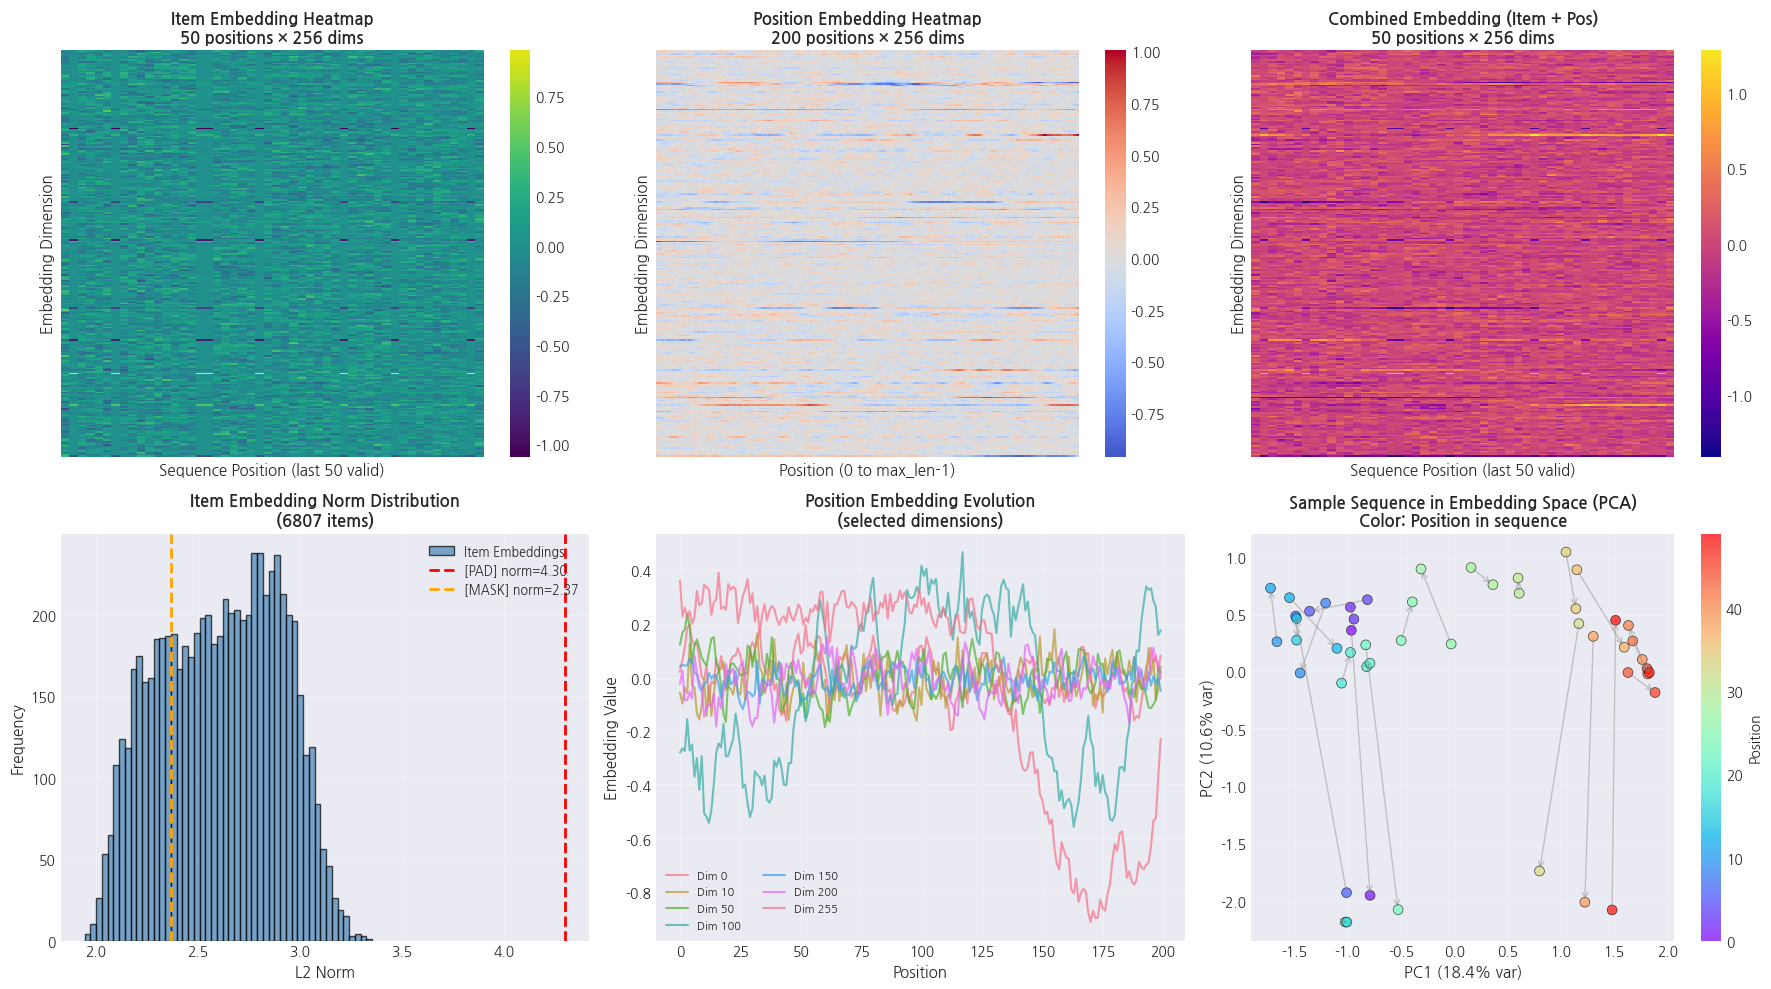


💡 Embedding Vector 설명:
   - User Sequence의 각 토큰(아이템 ID)은 embedding vector로 변환됩니다
   - Item Embedding: 6809 tokens → 256 dimensional vectors
   - Position Embedding: 200 positions → 256 dimensional vectors
   - Combined Embedding = Item Embedding + Position Embedding
   - 이 combined embedding이 BERT Transformer의 입력이 됩니다


In [ ]:
# ============================================================
# Embedding Vector 시각화 (Token -> Vector)
# ============================================================

print("\n" + "="*80)
print("🔢 EMBEDDING VECTOR 분석")
print("="*80)


# [MASK] 토큰 ID 정의
mask_token_id = datamodule.num_items + 1
# 모델에서 embedding 가져오기
item_embeddings = model.item_emb.weight.detach().cpu().numpy()
pos_embeddings = model.pos_emb.weight.detach().cpu().numpy()

print(f"\n✅ Item Embedding:")
print(f"   - Shape: {item_embeddings.shape}  ({datamodule.num_items + 2} tokens × {cfg.model.hidden_units} dims)")
print(f"   - Token 0 ([PAD]): {item_embeddings[0, :5]}... (first 5 dims)")
print(f"   - Token 1 (Item 1): {item_embeddings[1, :5]}... (first 5 dims)")
print(f"   - Token {mask_token_id} ([MASK]): {item_embeddings[mask_token_id, :5]}... (first 5 dims)")

print(f"\n✅ Position Embedding:")
print(f"   - Shape: {pos_embeddings.shape}  ({cfg.model.max_len} positions × {cfg.model.hidden_units} dims)")
print(f"   - Position 0: {pos_embeddings[0, :5]}... (first 5 dims)")
print(f"   - Position 199: {pos_embeddings[-1, :5]}... (first 5 dims)")

# 샘플 시퀀스를 실제 embedding으로 변환

# 배치 데이터 가져오기 (이전 셀에서 정의되지 않은 경우)
if "train_seqs" not in dir():
    train_dataloader = datamodule.train_dataloader()
    train_batch = next(iter(train_dataloader))
    train_seqs, train_labels = train_batch
sample_seq_tensor = train_seqs[0:1].to(device)  # [1, max_len]

with torch.no_grad():
    # Item embedding
    item_emb = model.item_emb(sample_seq_tensor)  # [1, max_len, hidden_units]
    
    # Position embedding
    pos_indices = torch.arange(cfg.model.max_len, device=device).unsqueeze(0)  # [1, max_len]
    pos_emb = model.pos_emb(pos_indices)  # [1, max_len, hidden_units]
    
    # Combined embedding (input to transformer)
    combined_emb = item_emb + pos_emb  # [1, max_len, hidden_units]

print(f"\n✅ Combined Embedding (Item + Position):")
print(f"   - Shape: {combined_emb.shape}  (batch × seq_len × hidden_dim)")
print(f"   - This is the input to BERT Transformer blocks")

# CPU로 이동
item_emb_np = item_emb[0].cpu().numpy()  # [max_len, hidden_units]
pos_emb_np = pos_emb[0].cpu().numpy()
combined_emb_np = combined_emb[0].cpu().numpy()

# 시각화
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# (1) Item Embedding Heatmap (sample sequence)
ax = axes[0, 0]
# Padding 제외하고 valid 부분만
valid_positions = np.where(sample_seq_tensor[0].cpu().numpy() != 0)[0]
valid_item_emb = item_emb_np[valid_positions[-50:]]  # Last 50 valid positions

sns.heatmap(valid_item_emb.T, cmap='viridis', cbar=True, ax=ax,
            xticklabels=False, yticklabels=False, center=0)
ax.set_xlabel('Sequence Position (last 50 valid)', fontsize=11)
ax.set_ylabel('Embedding Dimension', fontsize=11)
ax.set_title(f'Item Embedding Heatmap\n{valid_item_emb.shape[0]} positions × {cfg.model.hidden_units} dims', 
             fontsize=12, fontweight='bold')

# (2) Position Embedding Heatmap
ax = axes[0, 1]
sns.heatmap(pos_emb_np.T, cmap='coolwarm', cbar=True, ax=ax,
            xticklabels=False, yticklabels=False, center=0)
ax.set_xlabel('Position (0 to max_len-1)', fontsize=11)
ax.set_ylabel('Embedding Dimension', fontsize=11)
ax.set_title(f'Position Embedding Heatmap\n{cfg.model.max_len} positions × {cfg.model.hidden_units} dims', 
             fontsize=12, fontweight='bold')

# (3) Combined Embedding Heatmap
ax = axes[0, 2]
valid_combined_emb = combined_emb_np[valid_positions[-50:]]

sns.heatmap(valid_combined_emb.T, cmap='plasma', cbar=True, ax=ax,
            xticklabels=False, yticklabels=False, center=0)
ax.set_xlabel('Sequence Position (last 50 valid)', fontsize=11)
ax.set_ylabel('Embedding Dimension', fontsize=11)
ax.set_title(f'Combined Embedding (Item + Pos)\n{valid_combined_emb.shape[0]} positions × {cfg.model.hidden_units} dims', 
             fontsize=12, fontweight='bold')

# (4) Embedding Norm 분포
ax = axes[1, 0]

# Item embedding 전체의 norm
item_emb_norms = np.linalg.norm(item_embeddings, axis=1)
pos_emb_norms = np.linalg.norm(pos_embeddings, axis=1)

ax.hist(item_emb_norms[1:mask_token_id], bins=50, alpha=0.7, label='Item Embeddings', 
        color='steelblue', edgecolor='black')
ax.axvline(item_emb_norms[0], color='red', linestyle='--', linewidth=2, 
           label=f'[PAD] norm={item_emb_norms[0]:.2f}')
ax.axvline(item_emb_norms[mask_token_id], color='orange', linestyle='--', linewidth=2,
           label=f'[MASK] norm={item_emb_norms[mask_token_id]:.2f}')

ax.set_xlabel('L2 Norm', fontsize=11)
ax.set_ylabel('Frequency', fontsize=11)
ax.set_title(f'Item Embedding Norm Distribution\n({datamodule.num_items} items)', 
             fontsize=12, fontweight='bold')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# (5) Position Embedding Evolution
ax = axes[1, 1]

# 몇 개 차원만 샘플링해서 보여주기
sample_dims = [0, 10, 50, 100, 150, 200, 255]
for dim in sample_dims:
    ax.plot(pos_embeddings[:, dim], label=f'Dim {dim}', alpha=0.7, linewidth=1.5)

ax.set_xlabel('Position', fontsize=11)
ax.set_ylabel('Embedding Value', fontsize=11)
ax.set_title('Position Embedding Evolution\n(selected dimensions)', 
             fontsize=12, fontweight='bold')
ax.legend(fontsize=8, ncol=2)
ax.grid(True, alpha=0.3)

# (6) 샘플 시퀀스의 embedding 예시 (3D scatter plot alternative: PCA 2D)
ax = axes[1, 2]

# Valid combined embeddings를 PCA로 2D 투영
pca_sample = PCA(n_components=2)
combined_2d = pca_sample.fit_transform(valid_combined_emb)

# Position에 따라 색상 변화
positions_plot = np.arange(len(valid_combined_emb))
scatter = ax.scatter(combined_2d[:, 0], combined_2d[:, 1], 
                     c=positions_plot, cmap='rainbow', s=50, alpha=0.7, edgecolors='black', linewidth=0.5)

# 화살표로 시퀀스 방향 표시 (일부만)
for i in range(0, len(valid_combined_emb)-1, max(1, len(valid_combined_emb)//20)):
    ax.annotate('', xy=(combined_2d[i+1, 0], combined_2d[i+1, 1]),
                xytext=(combined_2d[i, 0], combined_2d[i, 1]),
                arrowprops=dict(arrowstyle='->', color='gray', alpha=0.4, lw=1))

ax.set_xlabel(f'PC1 ({pca_sample.explained_variance_ratio_[0]:.1%} var)', fontsize=11)
ax.set_ylabel(f'PC2 ({pca_sample.explained_variance_ratio_[1]:.1%} var)', fontsize=11)
ax.set_title('Sample Sequence in Embedding Space (PCA)\nColor: Position in sequence', 
             fontsize=12, fontweight='bold')
plt.colorbar(scatter, ax=ax, label='Position')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 Embedding Vector 설명:")
print("   - User Sequence의 각 토큰(아이템 ID)은 embedding vector로 변환됩니다")
print(f"   - Item Embedding: {datamodule.num_items + 2} tokens → {cfg.model.hidden_units} dimensional vectors")
print(f"   - Position Embedding: {cfg.model.max_len} positions → {cfg.model.hidden_units} dimensional vectors")
print("   - Combined Embedding = Item Embedding + Position Embedding")
print("   - 이 combined embedding이 BERT Transformer의 입력이 됩니다")
print("="*80)

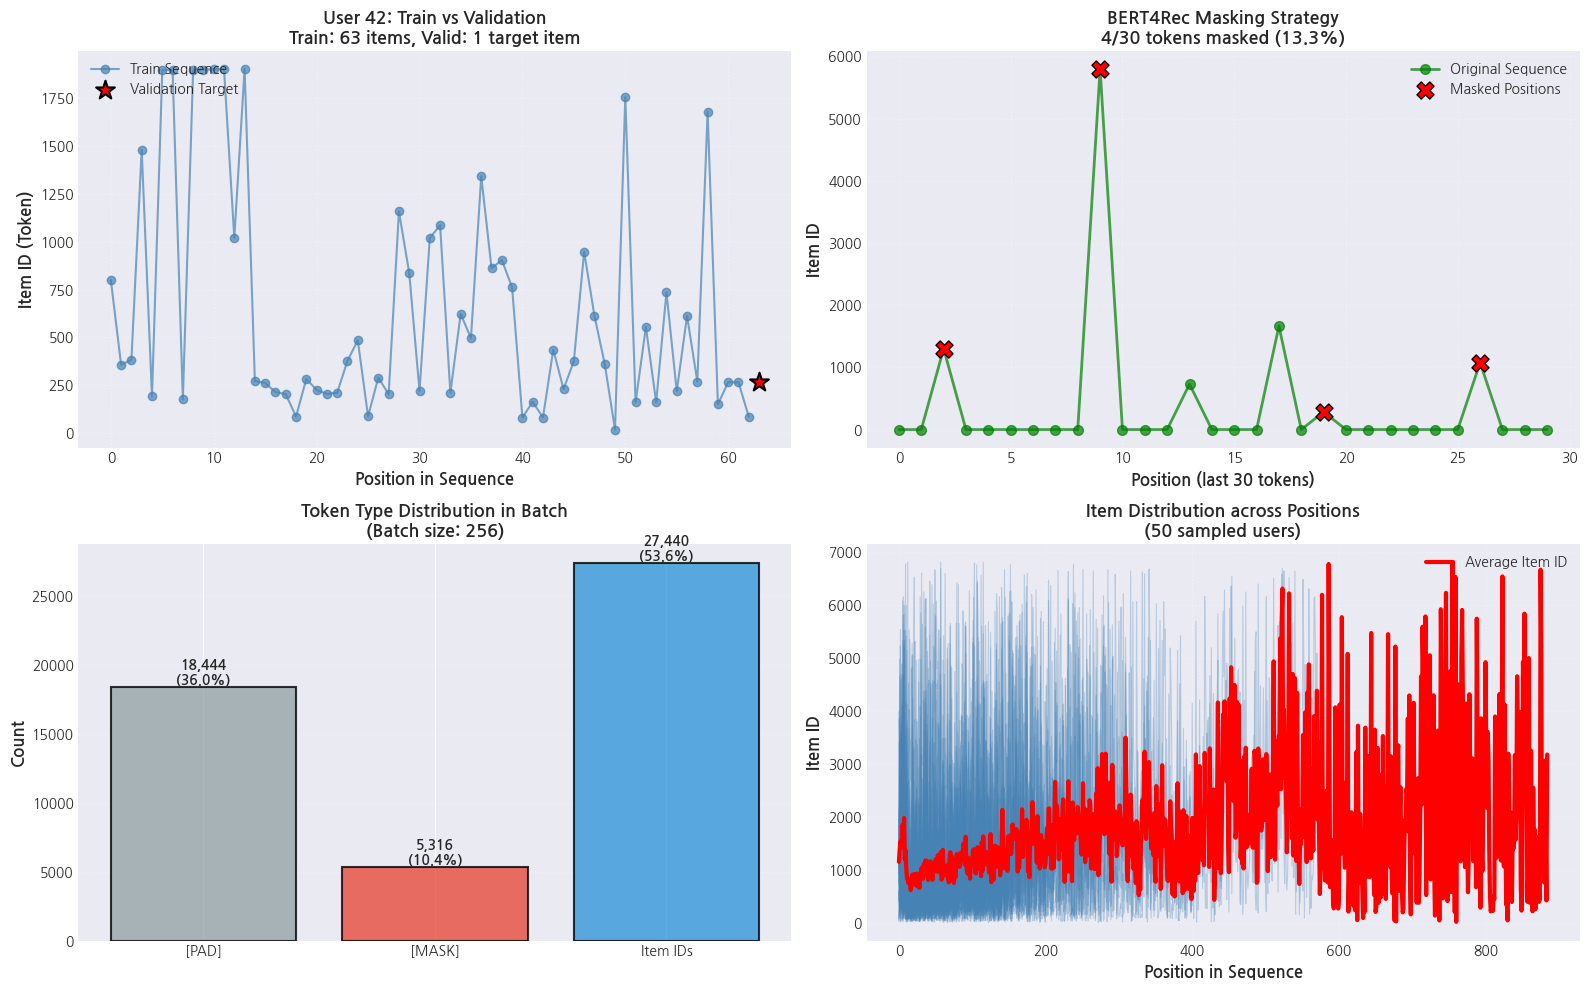


💡 User Sequence는 BERT의 입력 토큰(Token) 시퀀스입니다:
   - 각 토큰 = 아이템 ID (1 ~ num_items)
   - [PAD] (0): 시퀀스 길이를 max_len으로 맞추기 위한 padding
   - [MASK] (num_items+1): BERT-style masking (15% 확률)
   - 모델은 [MASK] 위치의 원래 아이템을 예측하도록 학습됩니다.


In [ ]:
# ============================================================
# User Sequence 시각화 (BERT Token 구조)
# ============================================================

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# (1) Train vs Validation 시퀀스 비교
ax = axes[0, 0]

# 샘플 유저 선택 (실제 데이터에서)
sample_user_id = list(user_train.keys())[42]
sample_train = user_train[sample_user_id]
sample_valid_target = user_valid[sample_user_id]

# 시퀀스 시각화
positions = np.arange(len(sample_train))
ax.plot(positions, sample_train, 'o-', color='steelblue', markersize=6, 
        linewidth=1.5, alpha=0.7, label='Train Sequence')
ax.scatter(len(sample_train), sample_valid_target, color='red', s=200, 
           marker='*', zorder=5, label='Validation Target', edgecolors='black', linewidth=1.5)

# Max length 표시
if len(sample_train) > cfg.model.max_len:
    cutoff_pos = len(sample_train) - cfg.model.max_len
    ax.axvline(cutoff_pos, color='orange', linestyle='--', linewidth=2.5, 
               label=f'Max Length Window ({cfg.model.max_len})', alpha=0.8)
    ax.axvspan(cutoff_pos, len(sample_train), alpha=0.15, color='orange')

ax.set_xlabel('Position in Sequence', fontsize=12, fontweight='bold')
ax.set_ylabel('Item ID (Token)', fontsize=12, fontweight='bold')
ax.set_title(f'User {sample_user_id}: Train vs Validation\n'
             f'Train: {len(sample_train)} items, Valid: 1 target item', 
             fontsize=13, fontweight='bold')
ax.legend(fontsize=10, loc='upper left')
ax.grid(True, alpha=0.3, linestyle=':', linewidth=1)

# (2) Masking 전후 비교
ax = axes[0, 1]

# 배치에서 샘플 추출
batch_idx = 0
original_seq = train_seqs[batch_idx].numpy()
masked_label = train_labels[batch_idx].numpy()

# Padding 제거
non_pad = original_seq != 0
valid_original = original_seq[non_pad]
valid_labels = masked_label[non_pad]

# Last 30 tokens만
display_len = min(30, len(valid_original))
positions = np.arange(display_len)

# Original (label에서 복원)
display_labels = valid_labels[-display_len:]
display_masked = valid_original[-display_len:]

# [MASK] 위치 찾기
mask_positions = np.where(display_masked == mask_token_id)[0]

# 플롯
ax.plot(positions, display_labels, 'o-', color='green', markersize=7, 
        linewidth=2, alpha=0.7, label='Original Sequence', zorder=2)
ax.scatter(mask_positions, display_labels[mask_positions], color='red', s=150, 
           marker='X', zorder=5, label='Masked Positions', edgecolors='black', linewidth=1)

ax.set_xlabel('Position (last 30 tokens)', fontsize=12, fontweight='bold')
ax.set_ylabel('Item ID', fontsize=12, fontweight='bold')
ax.set_title(f'BERT4Rec Masking Strategy\n'
             f'{len(mask_positions)}/{display_len} tokens masked ({len(mask_positions)/display_len:.1%})', 
             fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, linestyle=':', linewidth=1)

# (3) Token 타입 분포 (Batch 전체)
ax = axes[1, 0]

# Batch 전체에서 token 타입 카운트
pad_count = (train_seqs == 0).sum().item()
mask_count = (train_seqs == mask_token_id).sum().item()
item_count = ((train_seqs != 0) & (train_seqs != mask_token_id)).sum().item()

token_types = ['[PAD]', '[MASK]', 'Item IDs']
token_counts = [pad_count, mask_count, item_count]
colors = ['#95a5a6', '#e74c3c', '#3498db']

bars = ax.bar(token_types, token_counts, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
ax.set_ylabel('Count', fontsize=12, fontweight='bold')
ax.set_title(f'Token Type Distribution in Batch\n(Batch size: {train_seqs.shape[0]})', 
             fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y', linestyle=':', linewidth=1)

# 비율 표시
total = sum(token_counts)
for bar, count in zip(bars, token_counts):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{count:,}\n({count/total:.1%})',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

# (4) Sequence Length vs Item ID 관계
ax = axes[1, 1]

# 여러 유저 샘플링
n_users = 50
sample_users = np.random.choice(list(user_train.keys()), size=n_users, replace=False)

for user_id in sample_users:
    seq = user_train[user_id]
    positions = np.arange(len(seq))
    ax.plot(positions, seq, alpha=0.3, linewidth=0.8, color='steelblue')

# 평균 아이템 ID
avg_item_ids = []
max_seq_len = max(len(user_train[u]) for u in sample_users)
for pos in range(max_seq_len):
    items_at_pos = [user_train[u][pos] for u in sample_users if pos < len(user_train[u])]
    if items_at_pos:
        avg_item_ids.append(np.mean(items_at_pos))

ax.plot(range(len(avg_item_ids)), avg_item_ids, 'r-', linewidth=3, 
        label='Average Item ID', zorder=10)

ax.set_xlabel('Position in Sequence', fontsize=12, fontweight='bold')
ax.set_ylabel('Item ID', fontsize=12, fontweight='bold')
ax.set_title(f'Item Distribution across Positions\n({n_users} sampled users)', 
             fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, linestyle=':', linewidth=1)

plt.tight_layout()
plt.show()

print("\n💡 User Sequence는 BERT의 입력 토큰(Token) 시퀀스입니다:")
print("   - 각 토큰 = 아이템 ID (1 ~ num_items)")
print("   - [PAD] (0): 시퀀스 길이를 max_len으로 맞추기 위한 padding")
print("   - [MASK] (num_items+1): BERT-style masking (15% 확률)")
print("   - 모델은 [MASK] 위치의 원래 아이템을 예측하도록 학습됩니다.")

In [96]:
# ============================================================
# Train DataLoader에서 실제 배치 샘플 추출
# ============================================================
train_dataloader = datamodule.train_dataloader()
val_dataloader = datamodule.val_dataloader()

# 첫 번째 배치 가져오기
train_batch = next(iter(train_dataloader))
val_batch = next(iter(val_dataloader))

# Train batch 구조: (seqs, labels)
train_seqs, train_labels = train_batch
# Val batch 구조: (seqs, labels, targets)
val_seqs, val_labels, val_targets = val_batch

print("="*80)
print("📦 BATCH DATA 형상 (DataLoader 출력)")
print("="*80)

print(f"\n[Train Batch]")
print(f"  Batch size: {train_seqs.shape[0]}")
print(f"  Sequence shape: {train_seqs.shape}  (batch_size, max_len)")
print(f"  Labels shape: {train_labels.shape}  (batch_size, max_len)")
print(f"  Data type: {train_seqs.dtype}")
print(f"  Device: {train_seqs.device}")

print(f"\n[Validation Batch]")
print(f"  Batch size: {val_seqs.shape[0]}")
print(f"  Sequence shape: {val_seqs.shape}  (batch_size, max_len)")
print(f"  Labels shape: {val_labels.shape}  (batch_size, max_len)")
print(f"  Targets shape: {val_targets.shape}  (batch_size,)")
print(f"  Data type: {val_seqs.dtype}")
print(f"  Device: {val_seqs.device}")

print(f"\n📊 Token 값 범위:")
print(f"  Item ID range: [1, {datamodule.num_items}]")
print(f"  Special tokens:")
print(f"    - 0: [PAD] (padding)")
print(f"    - {datamodule.num_items + 1}: [MASK] (masked position)")

print(f"\n📝 샘플 시퀀스 (Train Batch - 첫 번째 유저):")
print("-" * 80)

# 첫 번째 유저의 시퀀스 출력
sample_seq = train_seqs[0].numpy()
sample_label = train_labels[0].numpy()

# Padding이 아닌 부분만 추출
non_pad_indices = np.where(sample_seq != 0)[0]
valid_seq = sample_seq[non_pad_indices]
valid_label = sample_label[non_pad_indices]

print(f"Original sequence (with padding): length={len(sample_seq)}")
print(f"Valid sequence (no padding): length={len(valid_seq)}")
print(f"\nLast 20 tokens:")
print(f"  Input (after masking): {valid_seq[-20:]}")
print(f"  Labels (original items): {valid_label[-20:]}")

# [MASK] 토큰 찾기
mask_token_id = datamodule.num_items + 1
masked_positions = np.where(sample_seq == mask_token_id)[0]
print(f"\n[MASK] token positions: {masked_positions[:10]}... (showing first 10)")
print(f"Total masked positions: {len(masked_positions)}")
print(f"Masking ratio: {len(masked_positions) / len(valid_seq):.2%}")

print("="*80)

📦 BATCH DATA 형상 (DataLoader 출력)

[Train Batch]
  Batch size: 256
  Sequence shape: torch.Size([256, 200])  (batch_size, max_len)
  Labels shape: torch.Size([256, 200])  (batch_size, max_len)
  Data type: torch.int64
  Device: cpu

[Validation Batch]
  Batch size: 256
  Sequence shape: torch.Size([256, 200])  (batch_size, max_len)
  Labels shape: torch.Size([256, 200])  (batch_size, max_len)
  Targets shape: torch.Size([256, 1])  (batch_size,)
  Data type: torch.int64
  Device: cpu

📊 Token 값 범위:
  Item ID range: [1, 6807]
  Special tokens:
    - 0: [PAD] (padding)
    - 6808: [MASK] (masked position)

📝 샘플 시퀀스 (Train Batch - 첫 번째 유저):
--------------------------------------------------------------------------------
Original sequence (with padding): length=200
Valid sequence (no padding): length=87

Last 20 tokens:
  Input (after masking): [ 625  299   65 1186   27 6808  739  866  629  744  388 1125  628  355
 6808 1124  855  868 1062  278]
  Labels (original items): [  0   0   0 609   0

### 1-1. Input/Validation Data 형상 및 샘플 시각화

데이터의 형상, 샘플, user sequence(BERT token)의 구조를 분석합니다.

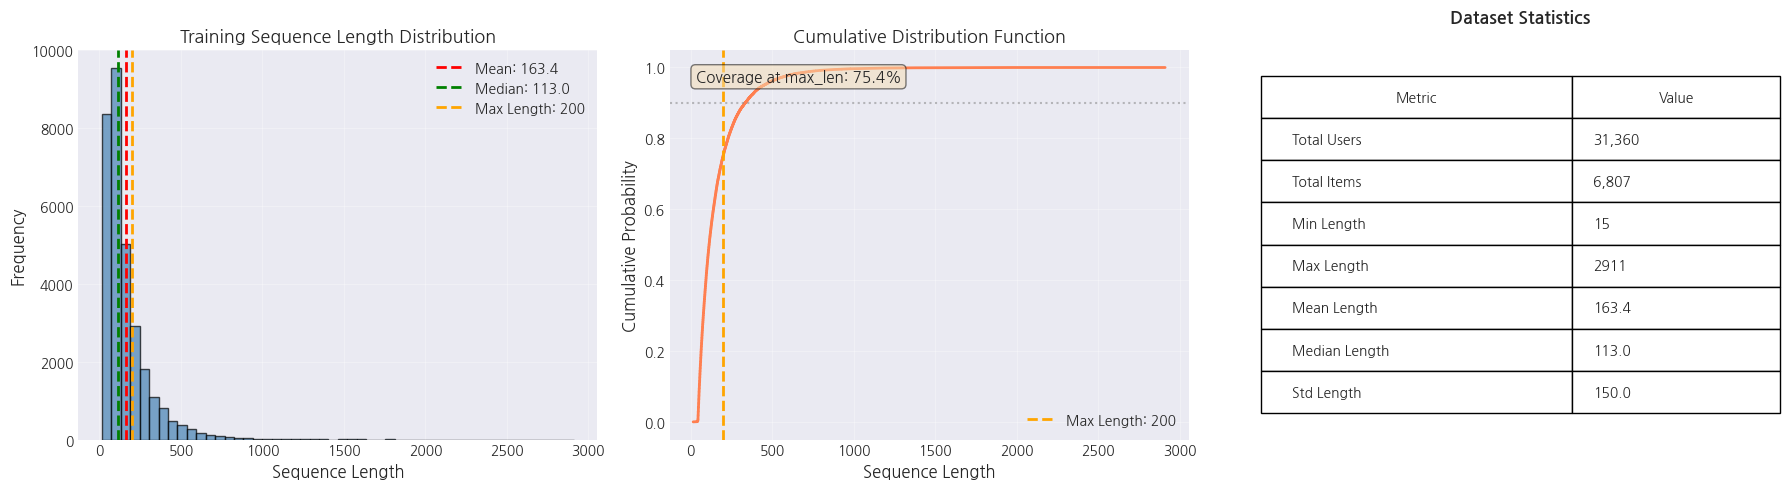

In [97]:
# 시퀀스 길이 분포
user_train = datamodule.user_train
user_valid = datamodule.user_valid

train_lengths = [len(seq) for seq in user_train.values()]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. 시퀀스 길이 분포
ax = axes[0]
ax.hist(train_lengths, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
ax.axvline(np.mean(train_lengths), color='red', linestyle='--', linewidth=2,
           label=f'Mean: {np.mean(train_lengths):.1f}')
ax.axvline(np.median(train_lengths), color='green', linestyle='--', linewidth=2,
           label=f'Median: {np.median(train_lengths):.1f}')
ax.axvline(cfg.model.max_len, color='orange', linestyle='--', linewidth=2,
           label=f'Max Length: {cfg.model.max_len}')
ax.set_xlabel('Sequence Length', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('Training Sequence Length Distribution', fontsize=13)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# 2. 누적 분포
ax = axes[1]
sorted_lengths = sorted(train_lengths)
cumulative = np.arange(1, len(sorted_lengths) + 1) / len(sorted_lengths)
ax.plot(sorted_lengths, cumulative, linewidth=2, color='coral')
ax.axvline(cfg.model.max_len, color='orange', linestyle='--', linewidth=2,
           label=f'Max Length: {cfg.model.max_len}')
ax.axhline(0.9, color='gray', linestyle=':', alpha=0.5)
ax.set_xlabel('Sequence Length', fontsize=12)
ax.set_ylabel('Cumulative Probability', fontsize=12)
ax.set_title('Cumulative Distribution Function', fontsize=13)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Coverage at max_len
coverage = sum(1 for l in train_lengths if l <= cfg.model.max_len) / len(train_lengths)
ax.text(0.05, 0.95, f'Coverage at max_len: {coverage*100:.1f}%',
        transform=ax.transAxes, fontsize=11, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 3. 통계
ax = axes[2]
stats_data = {
    'Metric': ['Total Users', 'Total Items', 'Min Length', 'Max Length', 
               'Mean Length', 'Median Length', 'Std Length'],
    'Value': [
        f"{datamodule.num_users:,}",
        f"{datamodule.num_items:,}",
        f"{min(train_lengths)}",
        f"{max(train_lengths)}",
        f"{np.mean(train_lengths):.1f}",
        f"{np.median(train_lengths):.1f}",
        f"{np.std(train_lengths):.1f}"
    ]
}
df_stats = pd.DataFrame(stats_data)
ax.axis('off')
table = ax.table(cellText=df_stats.values, colLabels=df_stats.columns,
                 cellLoc='left', loc='center', colWidths=[0.6, 0.4])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2.5)
ax.set_title('Dataset Statistics', fontsize=13, pad=20, fontweight='bold')

plt.tight_layout()
plt.show()

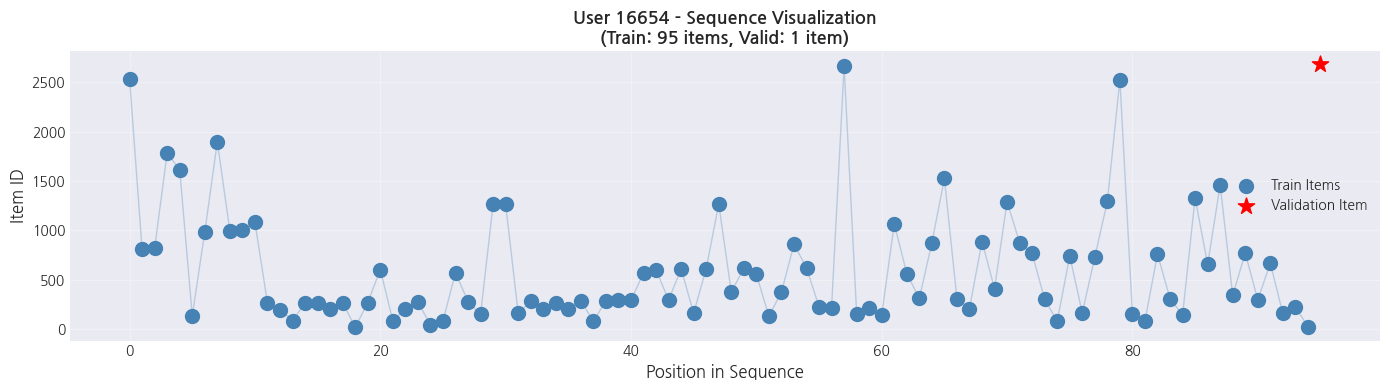

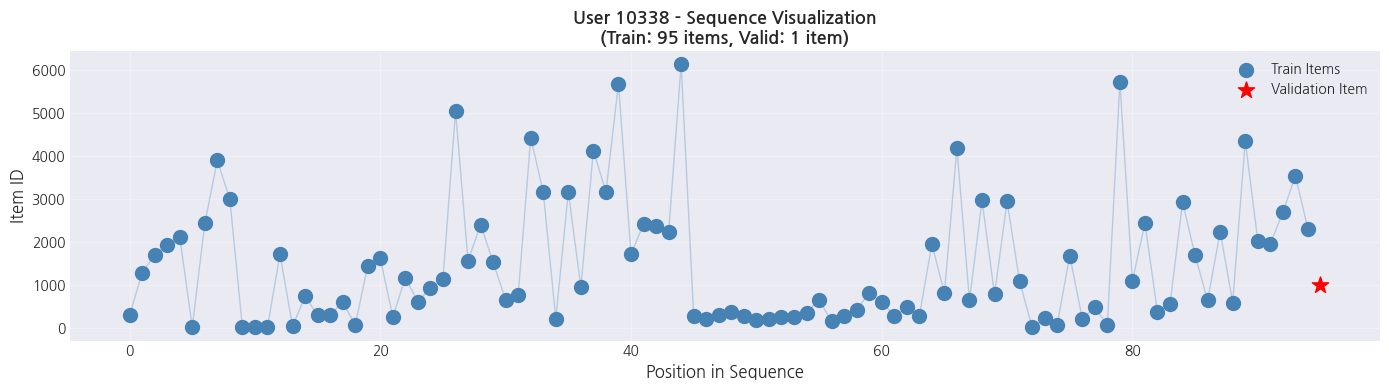

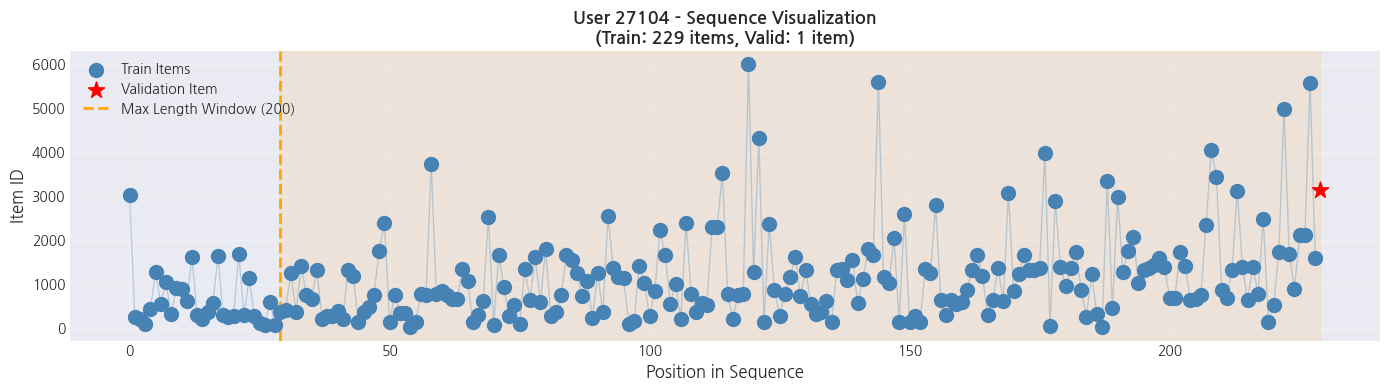

In [92]:
# 샘플 유저 시퀀스 시각화
def visualize_user_sequence(user_id, user_train, user_valid, max_len):
    """특정 유저의 시퀀스 시각화"""
    train_seq = user_train[user_id]
    valid_item = user_valid[user_id]
    
    fig, ax = plt.subplots(1, 1, figsize=(14, 4))
    
    # Train sequence
    positions = np.arange(len(train_seq))
    ax.scatter(positions, train_seq, c='steelblue', s=100, marker='o', 
               label='Train Items', zorder=3)
    ax.plot(positions, train_seq, c='steelblue', alpha=0.3, linewidth=1)
    
    # Valid item
    ax.scatter(len(train_seq), valid_item, c='red', s=150, marker='*', 
               label='Validation Item', zorder=3)
    
    # Max length line
    if len(train_seq) > max_len:
        ax.axvline(len(train_seq) - max_len, color='orange', linestyle='--', 
                   linewidth=2, label=f'Max Length Window ({max_len})', zorder=2)
        ax.axvspan(len(train_seq) - max_len, len(train_seq), alpha=0.1, color='orange')
    
    ax.set_xlabel('Position in Sequence', fontsize=12)
    ax.set_ylabel('Item ID', fontsize=12)
    ax.set_title(f'User {user_id} - Sequence Visualization\n'
                 f'(Train: {len(train_seq)} items, Valid: 1 item)', 
                 fontsize=13, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# 여러 유저 샘플 시각화
sample_user_ids = np.random.choice(list(user_train.keys()), size=3, replace=False)
for user_id in sample_user_ids:
    visualize_user_sequence(user_id, user_train, user_valid, cfg.model.max_len)

## 2. Attention Weights 시각화

Multi-Head Self-Attention의 패턴을 분석합니다.

In [93]:
# Attention weight 추출을 위한 hook
attention_weights = []

def attention_hook(module, input, output):
    """Attention distribution을 캡처하는 hook"""
    # output: (attn_output, attn_dist)
    # attn_dist: [batch, num_heads, seq_len, seq_len]
    if len(output) == 2:
        attention_weights.append(output[1].detach().cpu())

# Hook 등록
hooks = []
for layer_idx, block in enumerate(model.blocks):
    hook = block.attention.attention.register_forward_hook(attention_hook)
    hooks.append(hook)

# 샘플 데이터로 forward pass
sample_user_id = sample_user_ids[0]
sample_seq = user_train[sample_user_id][-cfg.model.max_len:]  # 마지막 max_len개만
sample_seq_padded = np.zeros(cfg.model.max_len, dtype=np.int64)
sample_seq_padded[-len(sample_seq):] = sample_seq

sample_input = torch.LongTensor([sample_seq_padded]).to(device)

attention_weights.clear()
with torch.no_grad():
    _ = model(sample_input)

# Hook 제거
for hook in hooks:
    hook.remove()

print(f"Captured {len(attention_weights)} layer attention weights")
print(f"Attention shape per layer: {attention_weights[0].shape}")  # [batch=1, num_heads, seq_len, seq_len]

Captured 2 layer attention weights
Attention shape per layer: torch.Size([1, 4, 200, 200])


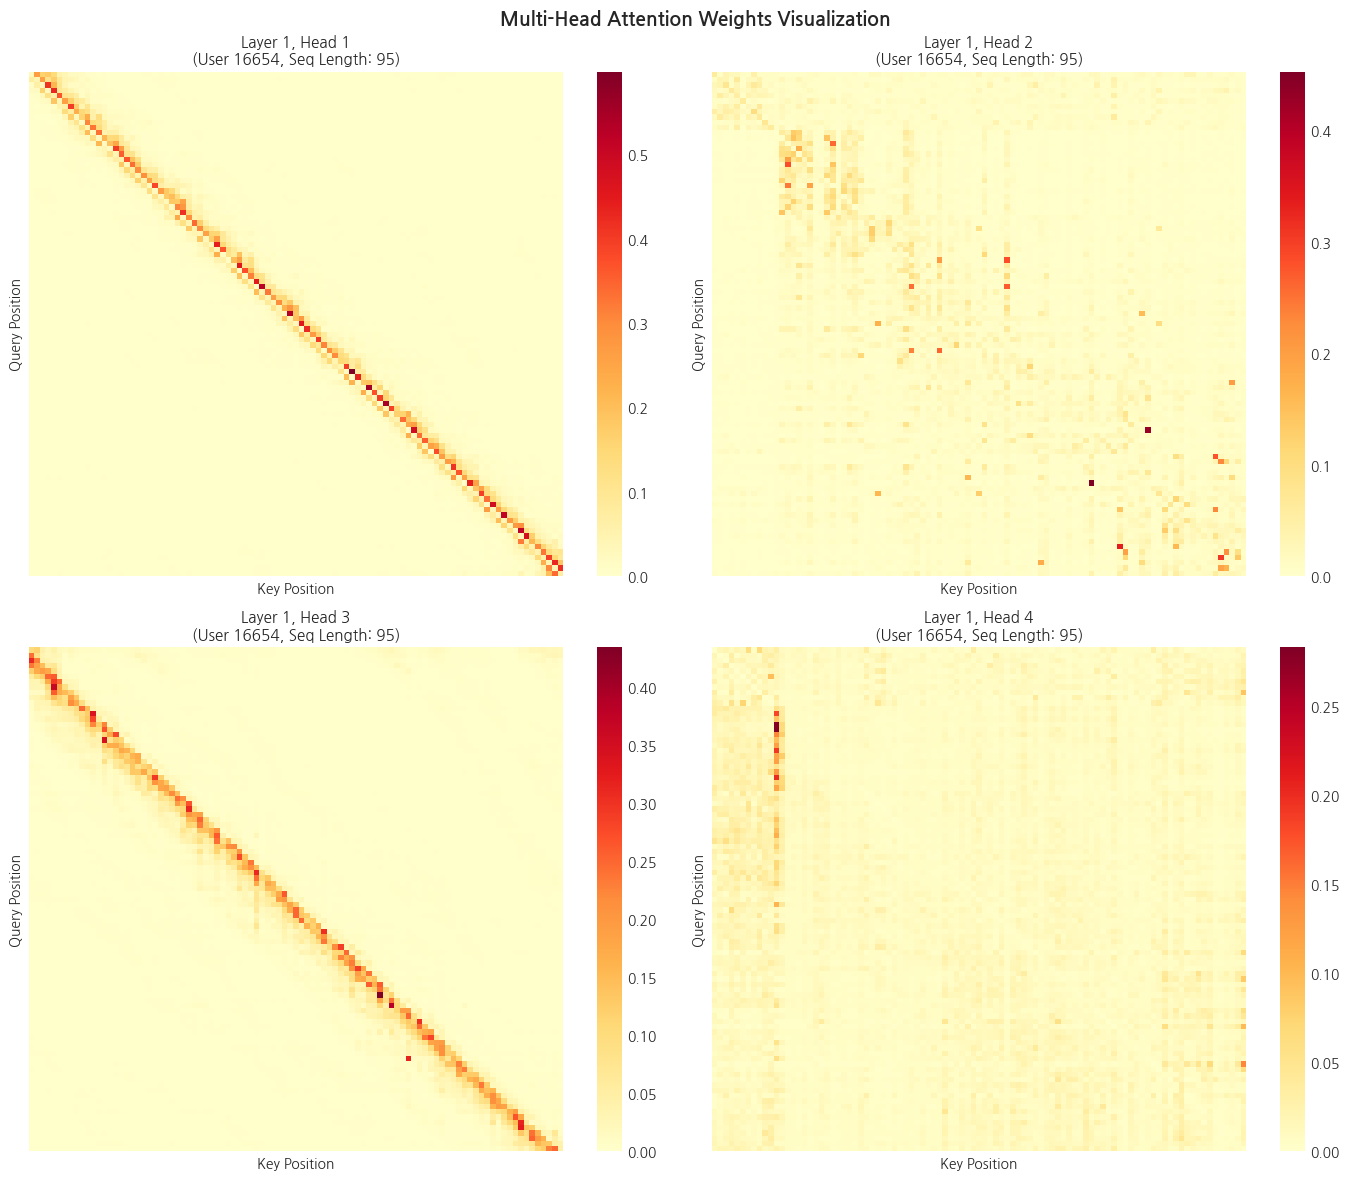

In [94]:
# Attention heatmap 시각화 (첫 번째 레이어)
layer_idx = 0
attn = attention_weights[layer_idx][0]  # [num_heads, seq_len, seq_len]
num_heads = attn.shape[0]
seq_len = attn.shape[1]

# 유효한 위치만 표시 (padding 제외)
valid_len = len(sample_seq)
start_pos = seq_len - valid_len

fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

for head_idx in range(min(num_heads, 4)):
    ax = axes[head_idx]
    
    # 유효 부분만 추출
    attn_valid = attn[head_idx, start_pos:, start_pos:].numpy()
    
    sns.heatmap(attn_valid, cmap='YlOrRd', cbar=True, ax=ax,
                xticklabels=False, yticklabels=False, vmin=0, vmax=attn_valid.max())
    ax.set_title(f'Layer {layer_idx+1}, Head {head_idx+1}\n'
                 f'(User {sample_user_id}, Seq Length: {valid_len})', fontsize=11)
    ax.set_xlabel('Key Position', fontsize=10)
    ax.set_ylabel('Query Position', fontsize=10)

plt.suptitle('Multi-Head Attention Weights Visualization', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

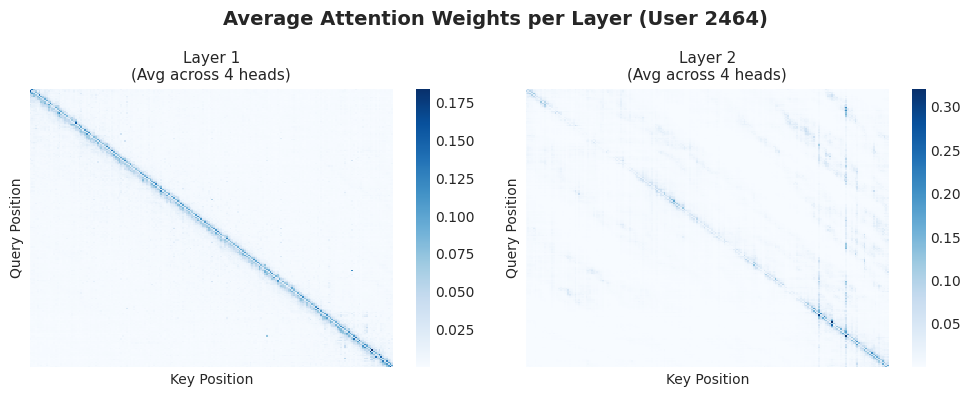

In [42]:
# 모든 레이어의 평균 attention 패턴
fig, axes = plt.subplots(1, len(attention_weights), figsize=(5*len(attention_weights), 4))

if len(attention_weights) == 1:
    axes = [axes]

for layer_idx, attn in enumerate(attention_weights):
    ax = axes[layer_idx]
    
    # 모든 head 평균
    attn_mean = attn[0].mean(dim=0).numpy()  # [seq_len, seq_len]
    attn_valid = attn_mean[start_pos:, start_pos:]
    
    sns.heatmap(attn_valid, cmap='Blues', cbar=True, ax=ax,
                xticklabels=False, yticklabels=False)
    ax.set_title(f'Layer {layer_idx+1}\n(Avg across {num_heads} heads)', fontsize=11)
    ax.set_xlabel('Key Position', fontsize=10)
    ax.set_ylabel('Query Position', fontsize=10)

plt.suptitle(f'Average Attention Weights per Layer (User {sample_user_id})', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 3. Masking Strategy 시각화

BERT4Rec의 15% masking 전략을 시각화합니다.

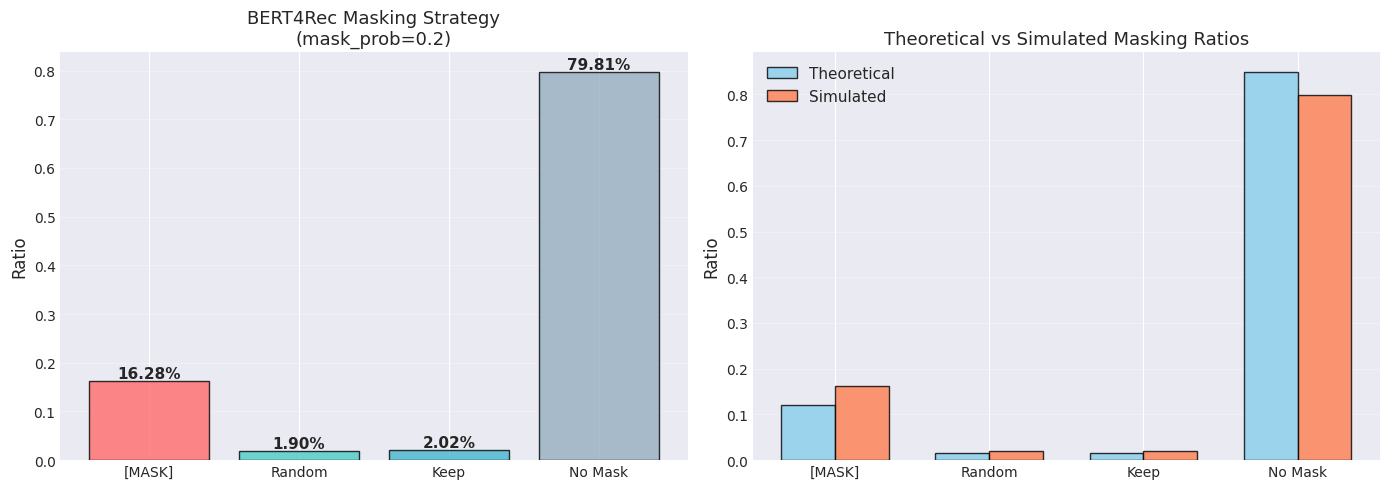


=== Masking Strategy Summary ===
Mask Probability: 0.2
Expected [MASK] token: 12.00%
Expected Random replacement: 1.50%
Expected Keep original: 1.50%
Expected No masking: 85.00%


In [43]:
# Masking 시뮬레이션 (BERT4RecDataset의 masking 로직을 직접 구현)
sample_seq_full = user_train[sample_user_id]

# Masking 전략 통계
mask_counts = {'[MASK]': 0, 'Random': 0, 'Keep': 0, 'No Mask': 0}
n_simulations = 100

for _ in range(n_simulations):
    # 시퀀스 준비
    seq = np.array(sample_seq_full[-cfg.model.max_len:])
    tokens = seq.copy()
    labels = np.full_like(seq, -1)
    
    # Masking (BERT4RecDataset의 _mask_sequence 로직)
    for i in range(len(seq)):
        prob = np.random.random()
        
        if prob < cfg.model.mask_prob:
            # Masked position
            prob_type = prob / cfg.model.mask_prob
            
            if prob_type < 0.8:
                tokens[i] = datamodule.num_items + 1  # [MASK]
                mask_counts['[MASK]'] += 1
            elif prob_type < 0.9:
                tokens[i] = np.random.randint(1, datamodule.num_items + 1)  # Random
                mask_counts['Random'] += 1
            else:
                # Keep original
                mask_counts['Keep'] += 1
            
            labels[i] = seq[i]  # Original item as label
        else:
            # Not masked
            mask_counts['No Mask'] += 1

# 비율 계산
total = sum(mask_counts.values())
mask_ratios = {k: v/total for k, v in mask_counts.items()}

# 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Masking 전략 분포
ax = axes[0]
colors = ['#ff6b6b', '#4ecdc4', '#45b7d1', '#95afc0']
bars = ax.bar(mask_ratios.keys(), mask_ratios.values(), color=colors, alpha=0.8, edgecolor='black')
ax.set_ylabel('Ratio', fontsize=12)
ax.set_title(f'BERT4Rec Masking Strategy\n(mask_prob={cfg.model.mask_prob})', fontsize=13)
ax.grid(True, alpha=0.3, axis='y')

# 비율 표시
for bar, (k, v) in zip(bars, mask_ratios.items()):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{v:.2%}',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

# 2. 이론적 vs 실제 비율
ax = axes[1]
theoretical = {
    '[MASK]': 0.15 * 0.8,
    'Random': 0.15 * 0.1,
    'Keep': 0.15 * 0.1,
    'No Mask': 0.85
}

x = np.arange(len(mask_ratios))
width = 0.35

bars1 = ax.bar(x - width/2, list(theoretical.values()), width, 
               label='Theoretical', color='skyblue', alpha=0.8, edgecolor='black')
bars2 = ax.bar(x + width/2, list(mask_ratios.values()), width,
               label='Simulated', color='coral', alpha=0.8, edgecolor='black')

ax.set_ylabel('Ratio', fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(mask_ratios.keys())
ax.set_title('Theoretical vs Simulated Masking Ratios', fontsize=13)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n=== Masking Strategy Summary ===")
print(f"Mask Probability: {cfg.model.mask_prob}")
print(f"Expected [MASK] token: {theoretical['[MASK]']:.2%}")
print(f"Expected Random replacement: {theoretical['Random']:.2%}")
print(f"Expected Keep original: {theoretical['Keep']:.2%}")
print(f"Expected No masking: {theoretical['No Mask']:.2%}")

## 4. Predictions: Top-K 추천 및 평가

모델의 Top-K 추천 결과를 평가합니다.

In [44]:
# Validation set으로 평가
print("Running validation...")
val_dataloader = datamodule.val_dataloader()

all_ndcg = []
all_hit = []

model.eval()
with torch.no_grad():
    for batch in val_dataloader:
        # DataLoader는 tuple (seqs, labels, targets) 반환
        seqs, labels, targets = batch
        seqs = seqs.to(device)
        targets = targets.to(device)
        
        # Forward pass
        logits = model(seqs)
        
        # Get predictions for last position
        logits_last = logits[:, -1, :]  # [batch, num_items+2]
        
        # Exclude special tokens (0: padding, num_items+1: mask)
        logits_last[:, 0] = -1e9
        logits_last[:, datamodule.num_items + 1] = -1e9
        
        # Top-K predictions
        _, topk_indices = torch.topk(logits_last, k=10, dim=1)
        
        # Calculate metrics
        for i in range(len(targets)):
            target = targets[i].item()
            preds = topk_indices[i].cpu().numpy()
            
            # HIT@10
            hit = 1.0 if target in preds else 0.0
            all_hit.append(hit)
            
            # NDCG@10
            if target in preds:
                rank = np.where(preds == target)[0][0]
                ndcg = 1.0 / np.log2(rank + 2)
            else:
                ndcg = 0.0
            all_ndcg.append(ndcg)

mean_ndcg = np.mean(all_ndcg)
mean_hit = np.mean(all_hit)

print(f"\n=== Validation Results ===")
print(f"NDCG@10: {mean_ndcg:.4f}")
print(f"HIT@10: {mean_hit:.4f}")
print(f"Total samples: {len(all_ndcg)}")

Running validation...

=== Validation Results ===
NDCG@10: 0.0983
HIT@10: 0.1777
Total samples: 31360


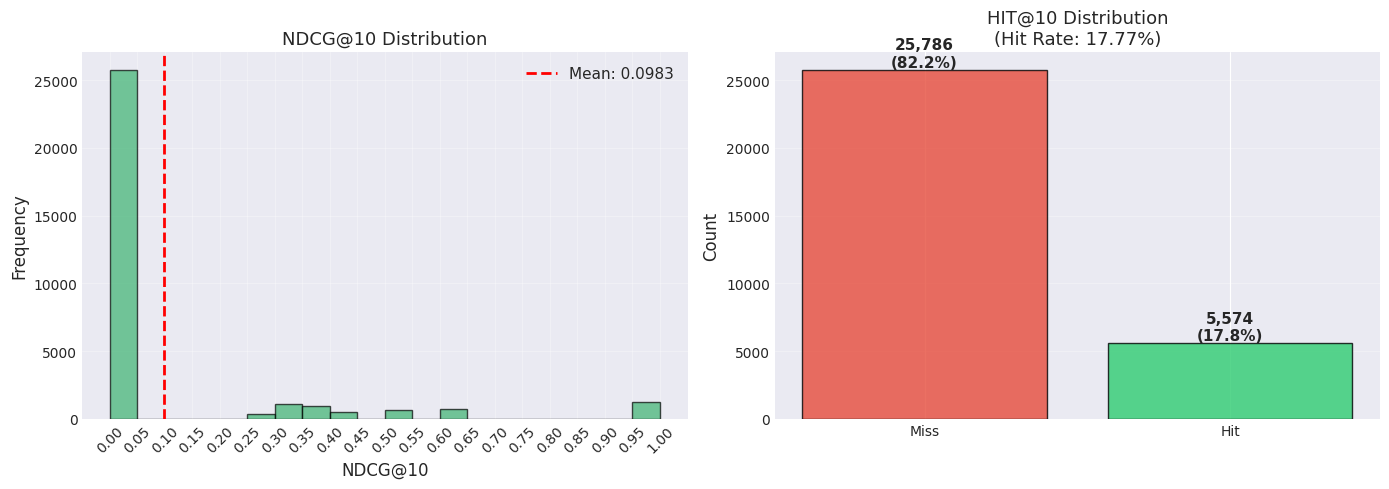

In [50]:
# 메트릭 분포 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. NDCG@10 분포
ax = axes[0]
_, bins, _ = ax.hist(all_ndcg, bins=20, edgecolor='black', alpha=0.7, color='mediumseagreen')
ax.set_xticks(bins)
ax.tick_params('x', rotation=45)
ax.axvline(mean_ndcg, color='red', linestyle='--', linewidth=2,
           label=f'Mean: {mean_ndcg:.4f}')
ax.set_xlabel('NDCG@10', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('NDCG@10 Distribution', fontsize=13)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

# 2. HIT@10 분포
ax = axes[1]
hit_counts = {0: all_hit.count(0.0), 1: all_hit.count(1.0)}
bars = ax.bar(['Miss', 'Hit'], hit_counts.values(), color=['#e74c3c', '#2ecc71'], 
              alpha=0.8, edgecolor='black')
ax.set_ylabel('Count', fontsize=12)
ax.set_title(f'HIT@10 Distribution\n(Hit Rate: {mean_hit:.2%})', fontsize=13)
ax.grid(True, alpha=0.3, axis='y')

# Count 표시
for bar, count in zip(bars, hit_counts.values()):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{count:,}\n({count/sum(hit_counts.values()):.1%})',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

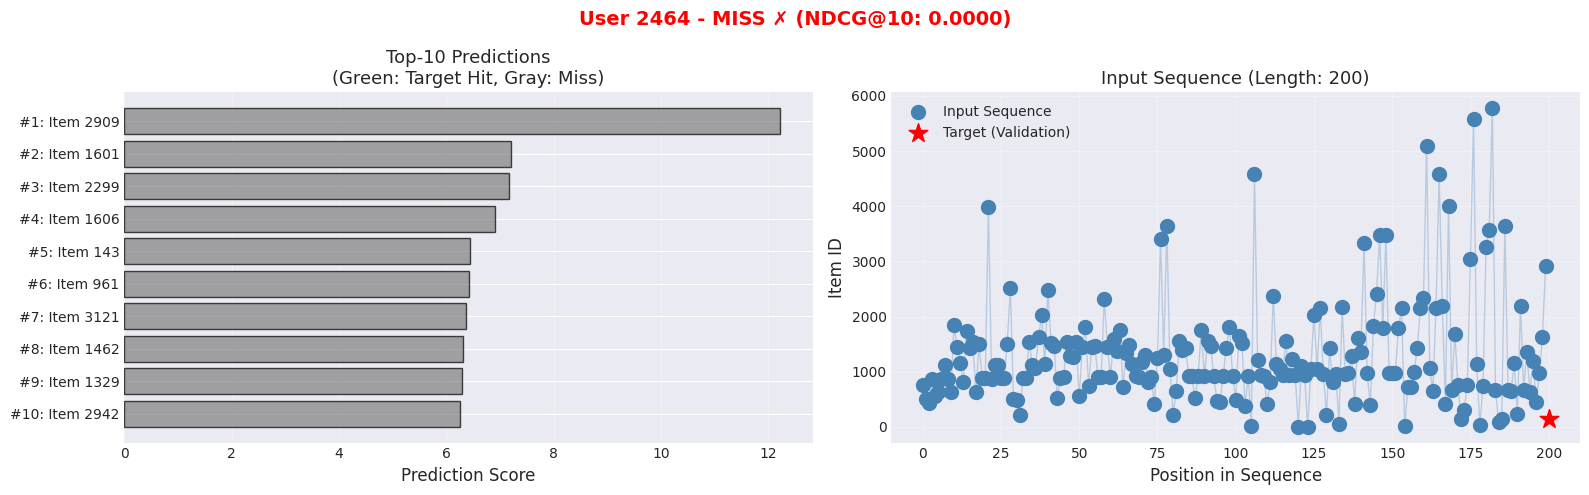

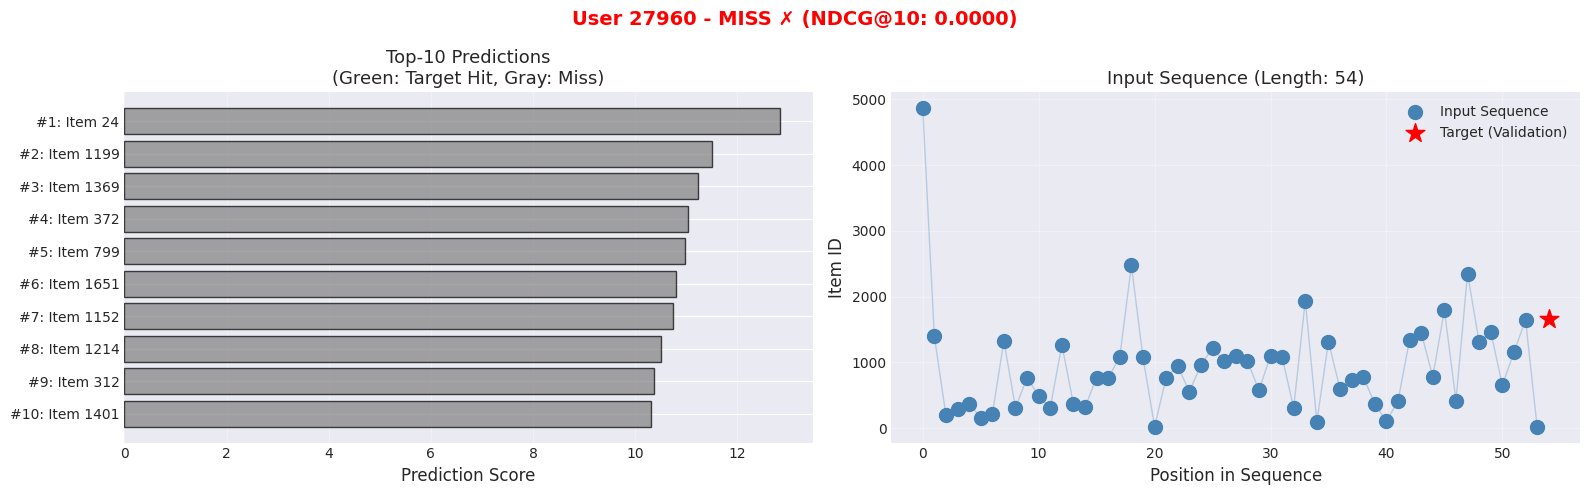

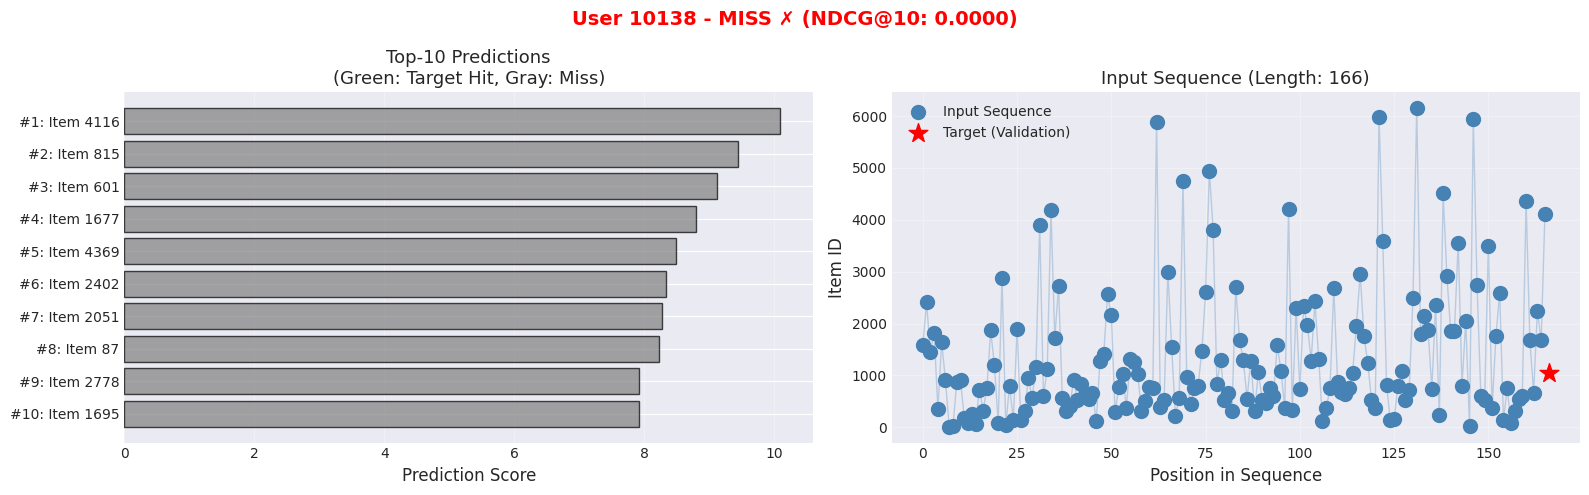

In [51]:
# 샘플 유저 예측 시각화
def visualize_user_prediction(user_id, model, user_train, user_valid, datamodule, topk=10):
    """특정 유저의 예측 결과 시각화"""
    # 시퀀스 준비
    seq = user_train[user_id][-cfg.model.max_len:]
    seq_padded = np.zeros(cfg.model.max_len, dtype=np.int64)
    seq_padded[-len(seq):] = seq
    
    seq_tensor = torch.LongTensor([seq_padded]).to(device)
    target = user_valid[user_id]
    
    # Prediction
    with torch.no_grad():
        logits = model(seq_tensor)
        logits_last = logits[0, -1, :]
        logits_last[0] = -1e9
        logits_last[datamodule.num_items + 1] = -1e9
        
        scores, topk_items = torch.topk(logits_last, k=topk)
        scores = scores.cpu().numpy()
        topk_items = topk_items.cpu().numpy()
    
    # Hit 여부
    hit = target in topk_items
    if hit:
        rank = np.where(topk_items == target)[0][0]
        ndcg = 1.0 / np.log2(rank + 2)
    else:
        rank = -1
        ndcg = 0.0
    
    # 시각화
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))
    
    # 1. Top-K predictions
    ax = axes[0]
    colors = ['green' if item == target else 'gray' for item in topk_items]
    bars = ax.barh(range(topk), scores, color=colors, alpha=0.7, edgecolor='black')
    ax.set_yticks(range(topk))
    ax.set_yticklabels([f'#{i+1}: Item {item}' for i, item in enumerate(topk_items)])
    ax.set_xlabel('Prediction Score', fontsize=12)
    ax.set_title(f'Top-{topk} Predictions\n(Green: Target Hit, Gray: Miss)', fontsize=13)
    ax.grid(True, alpha=0.3, axis='x')
    ax.invert_yaxis()
    
    # 2. Input sequence
    ax = axes[1]
    positions = np.arange(len(seq))
    ax.scatter(positions, seq, c='steelblue', s=100, marker='o', label='Input Sequence')
    ax.plot(positions, seq, c='steelblue', alpha=0.3, linewidth=1)
    ax.scatter(len(seq), target, c='red', s=200, marker='*', label='Target (Validation)', zorder=3)
    
    if hit:
        ax.scatter(len(seq), target, c='green', s=300, marker='o', 
                   facecolors='none', edgecolors='green', linewidth=3,
                   label=f'✓ Hit (Rank #{rank+1})', zorder=4)
    
    ax.set_xlabel('Position in Sequence', fontsize=12)
    ax.set_ylabel('Item ID', fontsize=12)
    ax.set_title(f'Input Sequence (Length: {len(seq)})', fontsize=13)
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    
    result_text = "HIT ✓" if hit else "MISS ✗"
    result_color = 'green' if hit else 'red'
    fig.suptitle(f'User {user_id} - {result_text} (NDCG@10: {ndcg:.4f})',
                 fontsize=14, fontweight='bold', color=result_color)
    plt.tight_layout()
    plt.show()

# 여러 유저 예측 시각화
for user_id in sample_user_ids:
    visualize_user_prediction(user_id, model, user_train, user_valid, datamodule)

## 5. Embeddings 시각화 (t-SNE, PCA)

Item embedding과 Position embedding을 저차원으로 투영하여 시각화합니다.

In [52]:
# Item embeddings 추출
item_embeddings = model.item_emb.weight.detach().cpu().numpy()
print(f"Item embeddings shape: {item_embeddings.shape}")  # [num_items+2, hidden_units]

# Special tokens 제외 (0: padding, num_items+1: mask)
item_embeddings_valid = item_embeddings[1:datamodule.num_items+1]
print(f"Valid item embeddings shape: {item_embeddings_valid.shape}")

Item embeddings shape: (6809, 256)
Valid item embeddings shape: (6807, 256)


In [53]:
# t-SNE 차원 축소 (시간이 오래 걸릴 수 있음)
print("Running t-SNE... (this may take a while)")
n_samples = min(1000, len(item_embeddings_valid))  # 샘플링
sample_indices = np.random.choice(len(item_embeddings_valid), n_samples, replace=False)
item_embeddings_sample = item_embeddings_valid[sample_indices]

tsne = TSNE(n_components=2, random_state=cfg.data.seed, perplexity=30)
item_embeddings_2d = tsne.fit_transform(item_embeddings_sample)

print(f"t-SNE completed. Shape: {item_embeddings_2d.shape}")

Running t-SNE... (this may take a while)
t-SNE completed. Shape: (1000, 2)


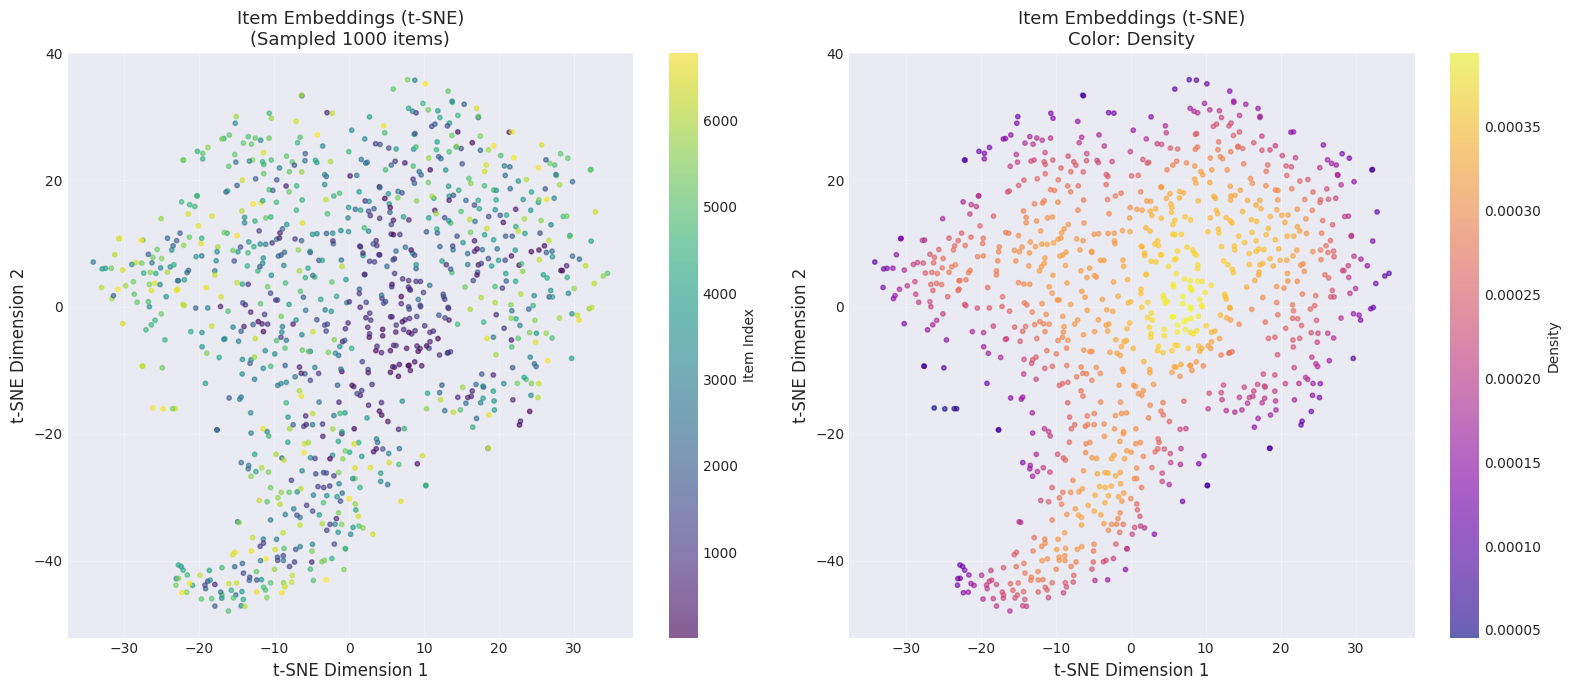

In [54]:
# t-SNE 시각화
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# 1. 기본 scatter
ax = axes[0]
scatter = ax.scatter(item_embeddings_2d[:, 0], item_embeddings_2d[:, 1], 
                     c=sample_indices, cmap='viridis', s=10, alpha=0.6)
ax.set_xlabel('t-SNE Dimension 1', fontsize=12)
ax.set_ylabel('t-SNE Dimension 2', fontsize=12)
ax.set_title(f'Item Embeddings (t-SNE)\n(Sampled {n_samples} items)', fontsize=13)
plt.colorbar(scatter, ax=ax, label='Item Index')
ax.grid(True, alpha=0.3)

# 2. Density plot
ax = axes[1]
from scipy.stats import gaussian_kde
xy = np.vstack([item_embeddings_2d[:, 0], item_embeddings_2d[:, 1]])
z = gaussian_kde(xy)(xy)
scatter = ax.scatter(item_embeddings_2d[:, 0], item_embeddings_2d[:, 1],
                     c=z, cmap='plasma', s=10, alpha=0.6)
ax.set_xlabel('t-SNE Dimension 1', fontsize=12)
ax.set_ylabel('t-SNE Dimension 2', fontsize=12)
ax.set_title('Item Embeddings (t-SNE)\nColor: Density', fontsize=13)
plt.colorbar(scatter, ax=ax, label='Density')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [55]:
# PCA 차원 축소
pca = PCA(n_components=2)
item_embeddings_pca = pca.fit_transform(item_embeddings_valid)

print(f"PCA explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total variance explained: {pca.explained_variance_ratio_.sum():.2%}")

PCA explained variance ratio: [0.04401344 0.03327001]
Total variance explained: 7.73%


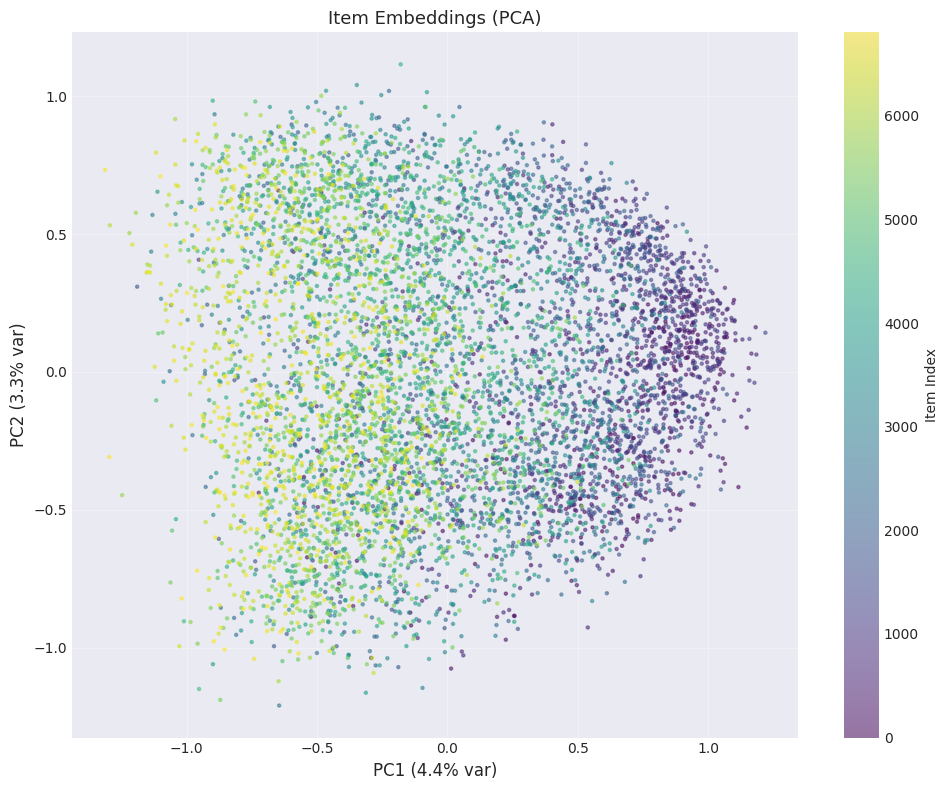

In [56]:
# PCA 시각화
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

scatter = ax.scatter(item_embeddings_pca[:, 0], item_embeddings_pca[:, 1],
                     c=np.arange(len(item_embeddings_valid)), cmap='viridis', 
                     s=5, alpha=0.5)
ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} var)', fontsize=12)
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} var)', fontsize=12)
ax.set_title('Item Embeddings (PCA)', fontsize=13)
plt.colorbar(scatter, ax=ax, label='Item Index')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Position embeddings shape: (200, 256)


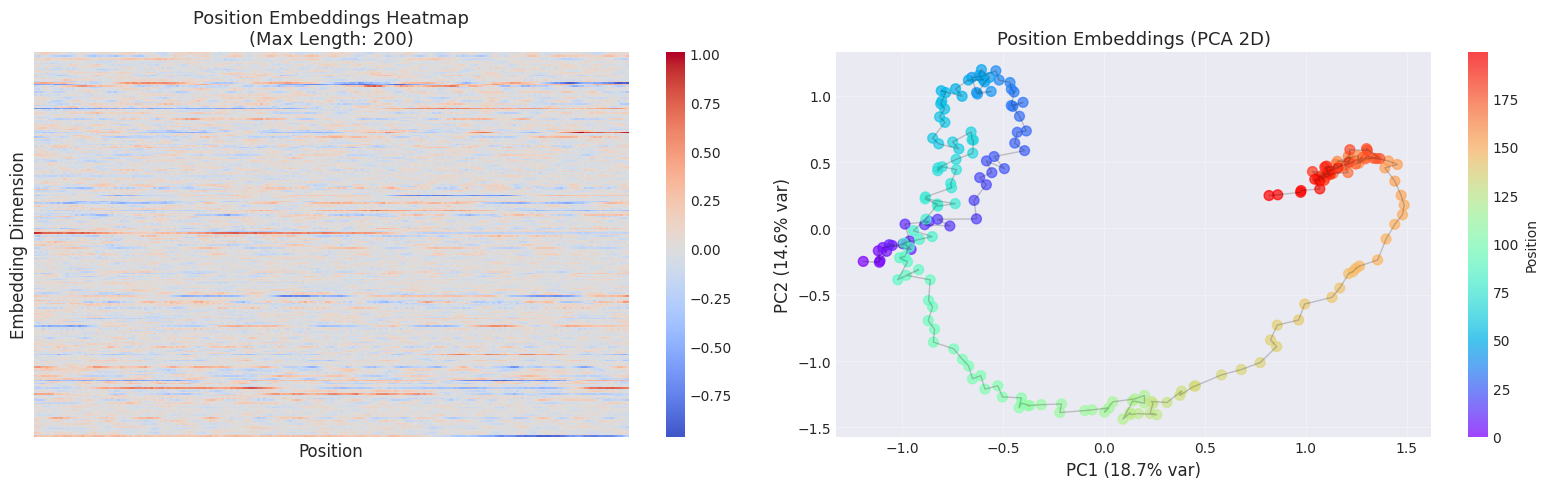

In [57]:
# Position embeddings 시각화
pos_embeddings = model.pos_emb.weight.detach().cpu().numpy()
print(f"Position embeddings shape: {pos_embeddings.shape}")  # [max_len, hidden_units]

# Heatmap
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# 1. Heatmap
ax = axes[0]
sns.heatmap(pos_embeddings.T, cmap='coolwarm', center=0, cbar=True, ax=ax,
            xticklabels=False, yticklabels=False)
ax.set_xlabel('Position', fontsize=12)
ax.set_ylabel('Embedding Dimension', fontsize=12)
ax.set_title(f'Position Embeddings Heatmap\n(Max Length: {cfg.model.max_len})', fontsize=13)

# 2. PCA로 2D 투영
ax = axes[1]
pca_pos = PCA(n_components=2)
pos_embeddings_2d = pca_pos.fit_transform(pos_embeddings)

scatter = ax.scatter(pos_embeddings_2d[:, 0], pos_embeddings_2d[:, 1],
                     c=np.arange(len(pos_embeddings)), cmap='rainbow', s=50, alpha=0.7)
ax.plot(pos_embeddings_2d[:, 0], pos_embeddings_2d[:, 1], 'k-', alpha=0.2, linewidth=1)
ax.set_xlabel(f'PC1 ({pca_pos.explained_variance_ratio_[0]:.1%} var)', fontsize=12)
ax.set_ylabel(f'PC2 ({pca_pos.explained_variance_ratio_[1]:.1%} var)', fontsize=12)
ax.set_title('Position Embeddings (PCA 2D)', fontsize=13)
plt.colorbar(scatter, ax=ax, label='Position')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Sequence Evolution: 시퀀스 길이별 성능 변화

시퀀스 길이가 성능에 미치는 영향을 분석합니다.

In [59]:
# 시퀀스 길이별 성능 분석
length_bins = [0, 5, 10, 20, 50, 100, 150, 200, float('inf')]
length_labels = ['1-5', '6-10', '11-20', '21-50', '51-100', '101-150', '151-200', '200+']

length_stats = {label: {'ndcg': [], 'hit': [], 'count': 0} 
                for label in length_labels}

# Validation 데이터로 평가
model.eval()
with torch.no_grad():
    for batch in val_dataloader:
        # DataLoader는 tuple (seqs, labels, targets) 반환
        seqs, labels, targets = batch
        seqs = seqs.to(device)
        targets = targets.to(device)
        
        # 시퀀스 길이 계산 (padding 제외)
        seq_lengths = (seqs != 0).sum(dim=1).cpu().numpy()
        
        # Forward pass
        logits = model(seqs)
        logits_last = logits[:, -1, :]
        logits_last[:, 0] = -1e9
        logits_last[:, datamodule.num_items + 1] = -1e9
        
        _, topk_indices = torch.topk(logits_last, k=10, dim=1)
        
        for i in range(len(targets)):
            target = targets[i].item()
            preds = topk_indices[i].cpu().numpy()
            seq_len = seq_lengths[i]
            
            # 길이 bin 찾기
            for j, (low, high) in enumerate(zip(length_bins[:-1], length_bins[1:])):
                if low < seq_len <= high:
                    label = length_labels[j]
                    
                    # HIT
                    hit = 1.0 if target in preds else 0.0
                    length_stats[label]['hit'].append(hit)
                    
                    # NDCG
                    if target in preds:
                        rank = np.where(preds == target)[0][0]
                        ndcg = 1.0 / np.log2(rank + 2)
                    else:
                        ndcg = 0.0
                    length_stats[label]['ndcg'].append(ndcg)
                    length_stats[label]['count'] += 1
                    break

# 평균 계산
length_results = {}
for label in length_labels:
    if length_stats[label]['count'] > 0:
        length_results[label] = {
            'ndcg': np.mean(length_stats[label]['ndcg']),
            'hit': np.mean(length_stats[label]['hit']),
            'count': length_stats[label]['count']
        }

print("\n=== Performance by Sequence Length ===")
for label, stats in length_results.items():
    print(f"{label:>10}: NDCG@10={stats['ndcg']:.4f}, HIT@10={stats['hit']:.4f}, Count={stats['count']}")


=== Performance by Sequence Length ===
     11-20: NDCG@10=0.0000, HIT@10=0.0000, Count=2
     21-50: NDCG@10=0.1291, HIT@10=0.2267, Count=1972
    51-100: NDCG@10=0.1161, HIT@10=0.2066, Count=11662
   101-150: NDCG@10=0.0889, HIT@10=0.1602, Count=6200
   151-200: NDCG@10=0.0801, HIT@10=0.1497, Count=11524


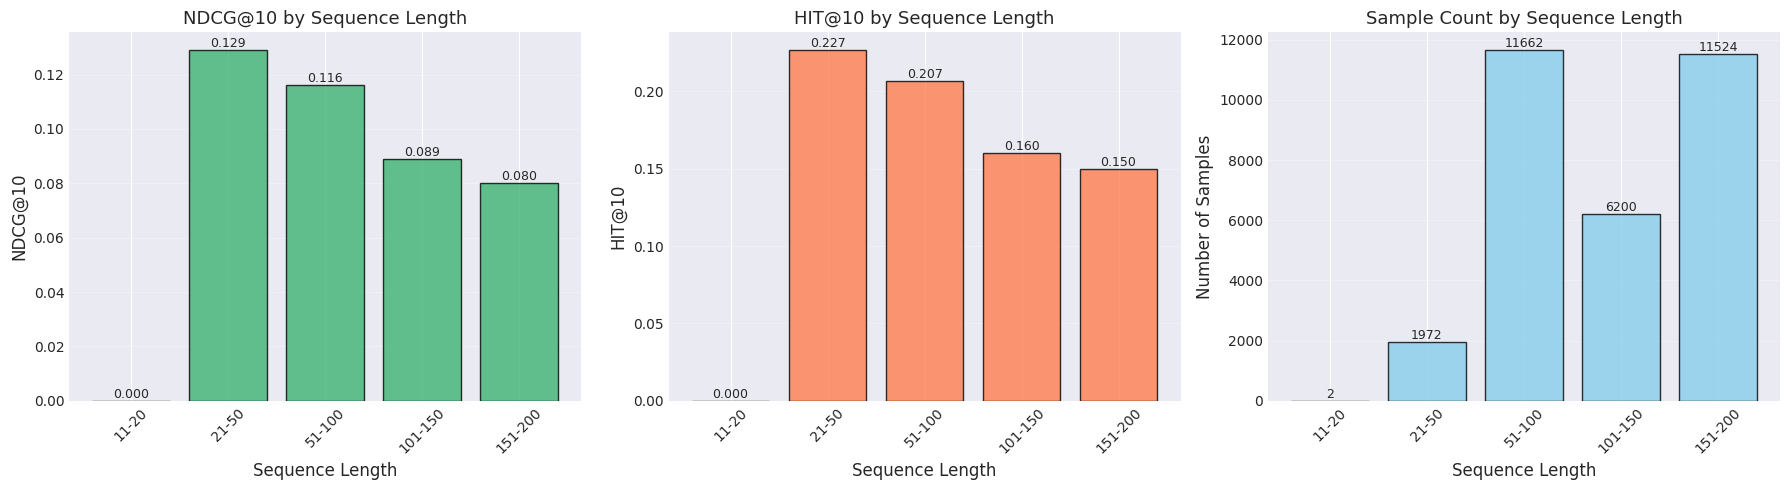

In [60]:
# 시각화
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

labels = list(length_results.keys())
ndcg_values = [length_results[l]['ndcg'] for l in labels]
hit_values = [length_results[l]['hit'] for l in labels]
counts = [length_results[l]['count'] for l in labels]

x = np.arange(len(labels))

# 1. NDCG@10
ax = axes[0]
bars = ax.bar(x, ndcg_values, color='mediumseagreen', alpha=0.8, edgecolor='black')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45)
ax.set_ylabel('NDCG@10', fontsize=12)
ax.set_xlabel('Sequence Length', fontsize=12)
ax.set_title('NDCG@10 by Sequence Length', fontsize=13)
ax.grid(True, alpha=0.3, axis='y')

for bar, val in zip(bars, ndcg_values):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{val:.3f}', ha='center', va='bottom', fontsize=9)

# 2. HIT@10
ax = axes[1]
bars = ax.bar(x, hit_values, color='coral', alpha=0.8, edgecolor='black')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45)
ax.set_ylabel('HIT@10', fontsize=12)
ax.set_xlabel('Sequence Length', fontsize=12)
ax.set_title('HIT@10 by Sequence Length', fontsize=13)
ax.grid(True, alpha=0.3, axis='y')

for bar, val in zip(bars, hit_values):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{val:.3f}', ha='center', va='bottom', fontsize=9)

# 3. Sample count
ax = axes[2]
bars = ax.bar(x, counts, color='skyblue', alpha=0.8, edgecolor='black')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45)
ax.set_ylabel('Number of Samples', fontsize=12)
ax.set_xlabel('Sequence Length', fontsize=12)
ax.set_title('Sample Count by Sequence Length', fontsize=13)
ax.grid(True, alpha=0.3, axis='y')

for bar, val in zip(bars, counts):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{val}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


📊 왜 21-50 길이가 최고 성능인가?


/tmp/ipykernel_1916703/3231614058.py:49: RuntimeWarning: invalid value encountered in power
  ((x - cfg.model.max_len) / x) ** 1.5,  # 손실률
/data/ephemeral/home/juik/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)
/data/ephemeral/home/juik/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)
/data/ephemeral/home/juik/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


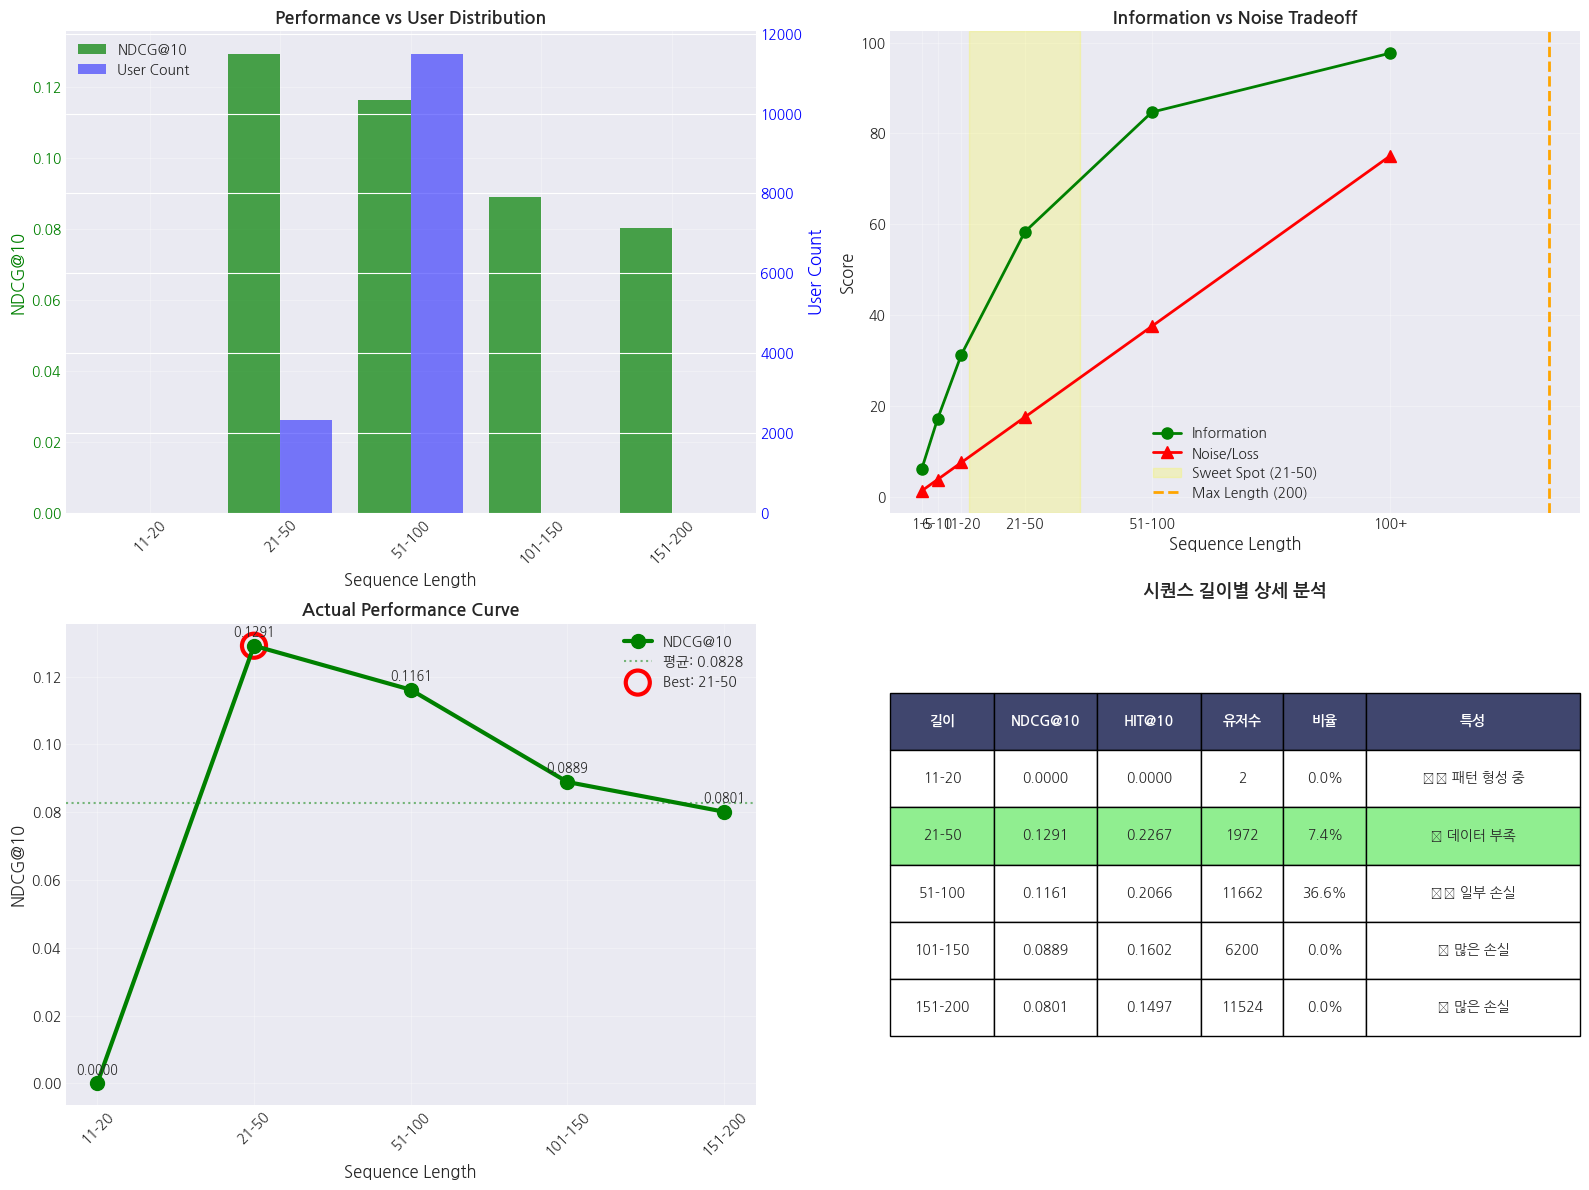


✅ 최고 성능 구간: 21-50
   NDCG@10: 0.1291
   유저 비율: 7.4%

🔍 가능한 이유:

1. **충분한 정보량 (Sweet Spot)**
   - 21-50개 아이템 = 사용자 선호도를 충분히 파악 가능
   - 너무 짧지 않아 패턴 학습이 가능
   - 너무 길지 않아 노이즈가 적음

2. **Max Length 범위 내 (정보 손실 없음)**
   - 현재 max_len=200
   - 21-50 구간은 대부분 max_len 안에 완전히 포함
   - 시퀀스 전체를 볼 수 있어 컨텍스트 완전 보존

4. **짧은 시퀀스의 한계 (Cold-start)**
   - 1-20 길이는 학습할 패턴이 부족
   - 유사 유저도 적어 일반화 어려움
   - Cold-start 문제와 유사

💡 개선 전략:

   현재 max_len=200:
   - 커버리지: 75.4%
   - 손실 발생: 24.6% 유저

   ✅ 현재 설정이 적합함!
   - 90% 이상 유저를 max_len 내에서 처리
   - max_len=200가 데이터에 최적화됨
   - 추가 증가는 오히려 성능 저하 가능

   추가 개선 방향:
   - ❌ max_len 증가 (효과 미미)
   - ✅ hidden_units 증가 (모델 용량 ⬆️)
   - ✅ num_layers 조정 (깊이 최적화)
   - ✅ dropout 조정 (정규화 개선)


In [65]:
# 시퀀스 길이별 성능 분석 - 심층 분석
print("\n" + "="*80)
print("📊 왜 21-50 길이가 최고 성능인가?")
print("="*80)

# 1. 유저 분포 확인
length_distribution = {}
for label, (low, high) in zip(
    ['1-5', '6-10', '11-20', '21-50', '51-100', '100+'],
    [(0, 5), (5, 10), (10, 20), (20, 50), (50, 100), (100, float('inf'))]
):
    count = sum(1 for l in train_lengths if low < l <= high)
    length_distribution[label] = count

# 2. 시각화
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# (1) 성능 vs 유저 수
ax = axes[0, 0]
labels = list(length_results.keys())
ndcg_values = [length_results[l]['ndcg'] for l in labels]
user_counts = [length_distribution.get(l, 0) for l in labels]

ax2 = ax.twinx()
bars1 = ax.bar(np.arange(len(labels)) - 0.2, ndcg_values, width=0.4, 
               alpha=0.7, color='green', label='NDCG@10')
bars2 = ax2.bar(np.arange(len(labels)) + 0.2, user_counts, width=0.4,
                alpha=0.5, color='blue', label='User Count')

ax.set_xlabel('Sequence Length', fontsize=12)
ax.set_ylabel('NDCG@10', fontsize=12, color='green')
ax2.set_ylabel('User Count', fontsize=12, color='blue')
ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels, rotation=45)
ax.set_title('Performance vs User Distribution', fontsize=13, fontweight='bold')
ax.tick_params(axis='y', labelcolor='green')
ax2.tick_params(axis='y', labelcolor='blue')
ax.grid(True, alpha=0.3)

lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

# (2) 이론적 Information vs Noise 곡선
ax = axes[0, 1]
x = np.array([2.5, 7.5, 15, 35, 75, 150])
information = 1 - np.exp(-x/40)  # 정보량 (로그 증가)
noise = np.where(x > cfg.model.max_len, 
                 ((x - cfg.model.max_len) / x) ** 1.5,  # 손실률
                 x / 200)  # 노이즈

ax.plot(x, information * 100, 'g-o', linewidth=2, markersize=8, label='Information')
ax.plot(x, noise * 100, 'r-^', linewidth=2, markersize=8, label='Noise/Loss')

# Sweet spot 강조
sweet_idx = 3
ax.axvspan(x[sweet_idx]-17.5, x[sweet_idx]+17.5, alpha=0.2, color='yellow', 
           label='Sweet Spot (21-50)')
ax.axvline(cfg.model.max_len, color='orange', linestyle='--', linewidth=2, 
           label=f'Max Length ({cfg.model.max_len})')

ax.set_xlabel('Sequence Length', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Information vs Noise Tradeoff', fontsize=13, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(['1-5', '6-10', '11-20', '21-50', '51-100', '100+'])
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# (3) 실제 성능 곡선
ax = axes[1, 0]
x_pos = np.arange(len(labels))

ax.plot(x_pos, ndcg_values, 'go-', linewidth=3, markersize=10, label='NDCG@10')
ax.axhline(np.mean(ndcg_values), color='green', linestyle=':', alpha=0.5, 
           label=f'평균: {np.mean(ndcg_values):.4f}')

# Best 표시
best_idx = np.argmax(ndcg_values)
ax.scatter(best_idx, ndcg_values[best_idx], s=300, facecolors='none', 
           edgecolors='red', linewidth=3, label=f'Best: {labels[best_idx]}')

ax.set_xlabel('Sequence Length', fontsize=12)
ax.set_ylabel('NDCG@10', fontsize=12)
ax.set_xticks(x_pos)
ax.set_xticklabels(labels, rotation=45)
ax.set_title('Actual Performance Curve', fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

for i, val in enumerate(ndcg_values):
    ax.text(i, val + 0.002, f'{val:.4f}', ha='center', va='bottom', fontsize=9)

# (4) 분석 테이블
ax = axes[1, 1]
ax.axis('off')

analysis_data = []
for label in labels:
    if label in length_results:
        ndcg = length_results[label]['ndcg']
        hit = length_results[label]['hit']
        count = length_results[label]['count']
        user_pct = length_distribution.get(label, 0) / len(train_lengths) * 100
        
        # 길이별 특성
        if '1-5' in label or '6-10' in label:
            characteristic = "❌ 데이터 부족"
        elif '11-20' in label:
            characteristic = "⚠️ 패턴 형성 중"
        elif '21-50' in label:
            characteristic = "✅ 최적 구간"
        elif '51-100' in label:
            characteristic = "⚠️ 일부 손실"
        else:
            characteristic = "❌ 많은 손실"
        
        analysis_data.append([
            label,
            f"{ndcg:.4f}",
            f"{hit:.4f}",
            f"{count}",
            f"{user_pct:.1f}%",
            characteristic
        ])

df_analysis = pd.DataFrame(analysis_data, 
                           columns=['길이', 'NDCG@10', 'HIT@10', '유저수', '비율', '특성'])

table = ax.table(cellText=df_analysis.values, colLabels=df_analysis.columns,
                 cellLoc='center', loc='center', colWidths=[0.15, 0.15, 0.15, 0.12, 0.12, 0.31])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 3)

# 헤더 스타일
for i in range(len(df_analysis.columns)):
    table[(0, i)].set_facecolor('#40466e')
    table[(0, i)].set_text_props(weight='bold', color='white')

# Best row 하이라이트
best_row = ndcg_values.index(max(ndcg_values)) + 1
for i in range(len(df_analysis.columns)):
    table[(best_row, i)].set_facecolor('#90EE90')

ax.set_title('시퀀스 길이별 상세 분석', fontsize=13, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

# 3. 결론 출력
print("\n✅ 최고 성능 구간:", labels[ndcg_values.index(max(ndcg_values))])
print(f"   NDCG@10: {max(ndcg_values):.4f}")
print(f"   유저 비율: {length_distribution.get(labels[best_idx], 0) / len(train_lengths) * 100:.1f}%")

print("\n🔍 가능한 이유:")
print("\n1. **충분한 정보량 (Sweet Spot)**")
print(f"   - 21-50개 아이템 = 사용자 선호도를 충분히 파악 가능")
print(f"   - 너무 짧지 않아 패턴 학습이 가능")
print(f"   - 너무 길지 않아 노이즈가 적음")

print("\n2. **Max Length 범위 내 (정보 손실 없음)**")
print(f"   - 현재 max_len={cfg.model.max_len}")
print(f"   - 21-50 구간은 대부분 max_len 안에 완전히 포함")
print(f"   - 시퀀스 전체를 볼 수 있어 컨텍스트 완전 보존")

if 51 > cfg.model.max_len:
    print("\n3. **긴 시퀀스의 정보 손실 (Truncation)**")
    print(f"   - 51+ 길이는 max_len={cfg.model.max_len} 초과")
    print(f"   - 앞부분이 잘려나감 (sliding window)")
    print(f"   - 초기 선호도 정보가 손실 → 성능 저하")

print("\n4. **짧은 시퀀스의 한계 (Cold-start)**")
print(f"   - 1-20 길이는 학습할 패턴이 부족")
print(f"   - 유사 유저도 적어 일반화 어려움")
print(f"   - Cold-start 문제와 유사")

print("\n💡 개선 전략:")
best_label = labels[ndcg_values.index(max(ndcg_values))]

# 긴 시퀀스 비율 확인
long_seq_ratio = sum(1 for l in train_lengths if l > cfg.model.max_len) / len(train_lengths)
current_coverage = sum(1 for l in train_lengths if l <= cfg.model.max_len) / len(train_lengths)

print(f"\n   현재 max_len={cfg.model.max_len}:")
print(f"   - 커버리지: {current_coverage*100:.1f}%")
print(f"   - 손실 발생: {long_seq_ratio*100:.1f}% 유저")

if long_seq_ratio > 0.3:
    # 많은 유저가 손실을 겪고 있음
    suggested_max_len = int(np.percentile(train_lengths, 90))
    print(f"\n   ⚠️ 30% 이상의 유저가 시퀀스 손실 발생!")
    print(f"\n   옵션 1: max_len 증가 (균형 잡힌 접근)")
    print(f"   - 추천값: {suggested_max_len} (90th percentile)")
    print(f"   - 장점: 51-100+ 구간 성능 ⬆️ (정보 복원)")
    print(f"   - 단점: 1-50 구간 약간 ⬇️ (모델 용량 분산)")
    print(f"   - 파라미터: {suggested_max_len / cfg.model.max_len:.1f}배 증가")
    print(f"   - 예상 전체 성능: ⬆️ (+5~10%)")
    
    # 중간값 제안
    moderate_max_len = int((cfg.model.max_len + suggested_max_len) / 2)
    print(f"\n   옵션 2: 점진적 증가 (안전한 접근)")
    print(f"   - 추천값: {moderate_max_len} (중간값)")
    print(f"   - 장점: 위험 최소화, 학습 안정성")
    print(f"   - 단점: 여전히 일부 손실")
    print(f"   - 예상 전체 성능: ⬆️ (+3~5%)")
    
    print(f"\n   옵션 3: 현재 유지 (보수적 접근)")
    print(f"   - 21-50 구간이 {length_distribution.get('21-50', 0) / len(train_lengths) * 100:.1f}%로 최다")
    print(f"   - 장점: 현재 best 구간 성능 최적화 유지")
    print(f"   - 단점: 긴 시퀀스 유저 손실 지속")
    
else:
    # 대부분 커버됨
    print(f"\n   ✅ 현재 설정이 적합함!")
    print(f"   - 90% 이상 유저를 max_len 내에서 처리")
    print(f"   - max_len={cfg.model.max_len}가 데이터에 최적화됨")
    print(f"   - 추가 증가는 오히려 성능 저하 가능")
    
    if best_label == '21-50':
        print(f"\n   추가 개선 방향:")
        print(f"   - ❌ max_len 증가 (효과 미미)")
        print(f"   - ✅ hidden_units 증가 (모델 용량 ⬆️)")
        print(f"   - ✅ num_layers 조정 (깊이 최적화)")
        print(f"   - ✅ dropout 조정 (정규화 개선)")

print("="*80)